In [25]:
# Import the Libraries
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [26]:
from torch.utils.data import random_split

# Define the dataset and transformations
tensor_transform = transforms.ToTensor()
dataset = datasets.MNIST(root="./data",
                         train=True,
                         download=True,
                         transform=tensor_transform)

# Split dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Define data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=100,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=50,
                                         shuffle=False)
# Test dataset and loader remain the same
test_dataset = datasets.MNIST(root="./data",
                               train=False,
                               download=True,
                               transform=tensor_transform)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=50,
                                          shuffle=False)


In [27]:
print(len(val_dataset))
print(len(test_dataset))
print(len(train_dataset))

12000
10000
48000


28* italicised text28=784 ->256-> 128 -> 64 -> 32 ->16 -> 8 -> 16 -> 32 -> 64 ->128 ->256 ->784

---



In [37]:
# Function to add Gaussian noise to images
def add_noise(images, sigma):
    noise = torch.randn_like(images) * sigma
    noisy_images = images + noise
    return noisy_images  # Ensure pixel values are between 0 and 1


In [29]:
import torch
from skimage.metrics import structural_similarity as ssim
import numpy as np
import matplotlib.pyplot as plt

# Evaluate the autoencoder model on validation set and plot reconstructed images
def evaluate_model(model, data_loader, criterion):
    model.eval()
    total_recon_loss = 0.0
    ssim_scores = []
    original_images = []
    reconstructed_images = []

    with torch.no_grad():
        for batch in data_loader:
            images, _ = batch[0].to(device), batch[1].to(device)
            images = images.view(images.size(0), -1)

            # Forward pass
            outputs = model(images)
            recon_loss = criterion(outputs, images)

            # Compute SSIM and store images for visualization
            for i in range(len(images)):
                original_image_np = images[i].view(28, 28).cpu().numpy()  # Move to CPU and convert to NumPy array
                reconstructed_image_np = outputs[i].view(28, 28).cpu().numpy()  # Move to CPU and convert to NumPy array
                ssim_score = ssim(original_image_np, reconstructed_image_np)
                ssim_scores.append(ssim_score)
                original_images.append(original_image_np)
                reconstructed_images.append(reconstructed_image_np)

            total_recon_loss += recon_loss.item() * images.size(0)

    # Calculate average reconstruction loss
    avg_recon_loss = total_recon_loss / len(data_loader.dataset)
    # Calculate average SSIM
    avg_ssim = np.mean(ssim_scores)

    # Plot a randomly selected original and reconstructed image
    idx = np.random.randint(len(original_images))
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original_images[idx], cmap='gray')
    axes[0].set_title('Original')
    axes[0].axis('off')
    axes[1].imshow(reconstructed_images[idx], cmap='gray')
    axes[1].set_title('Reconstructed')
    axes[1].axis('off')
    plt.show()

    return avg_recon_loss, avg_ssim


In [30]:

# Training epoch (internal function used by train_model)
def train_epoch(model, data_loader, optimizer, criterion,sigma,is_noisy):
    model.train()
    total_loss = 0.0
    for batch in data_loader:
        images, _ = batch[0].to(device), batch[1].to(device)
        images = images.view(images.size(0), -1)

        if(is_noisy):
            images = add_noise(images, sigma)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)

    # Calculate average loss
    avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss

In [31]:
import torch
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Train the autoencoder model
def train_model(model, num_epochs, train_loader, val_loader, optimizer, criterion,sigma,is_noisy=0):
    avg_ssim_values = []
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, optimizer, criterion,sigma,is_noisy)
        val_recon_loss, val_ssim = evaluate_model(model, val_loader, criterion)
        avg_ssim_values.append(val_ssim)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_recon_loss:.4f}, Val SSIM: {val_ssim:.4f}')
    print('Training finished.')
    return avg_ssim_values


In [32]:
class AutoEncoder(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # Encoder
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28*28, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 16),
        )

        # Decoder
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(16, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 28 * 28),
            torch.nn.Sigmoid()  # Sigmoid for pixel values in [0, 1] range
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [33]:
# Model Initialization
model = AutoEncoder()
model=model.to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

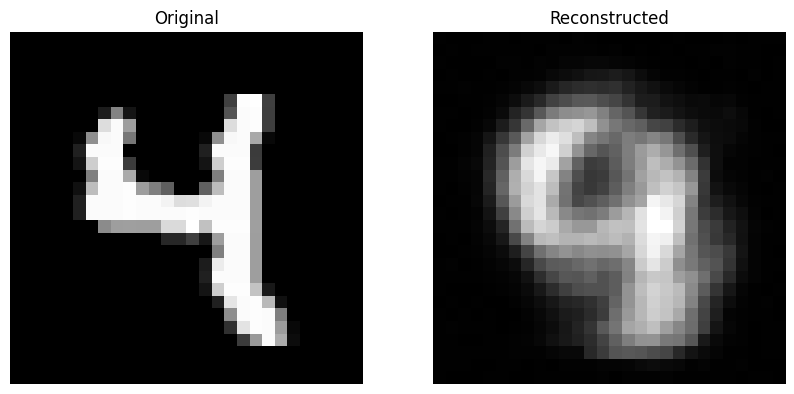

Epoch [1/10], Train Loss: 0.0637, Val Loss: 0.0500, Val SSIM: 0.4577


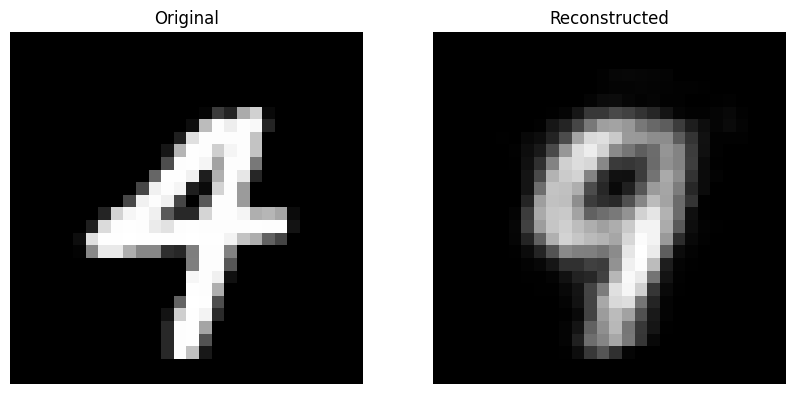

Epoch [2/10], Train Loss: 0.0440, Val Loss: 0.0383, Val SSIM: 0.6015


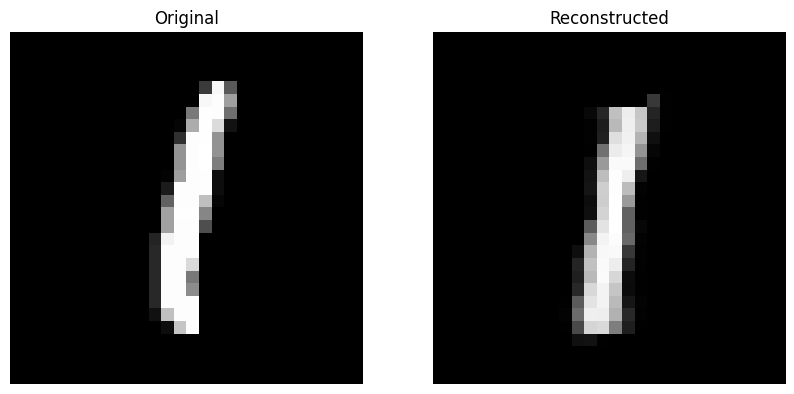

Epoch [3/10], Train Loss: 0.0351, Val Loss: 0.0323, Val SSIM: 0.6680


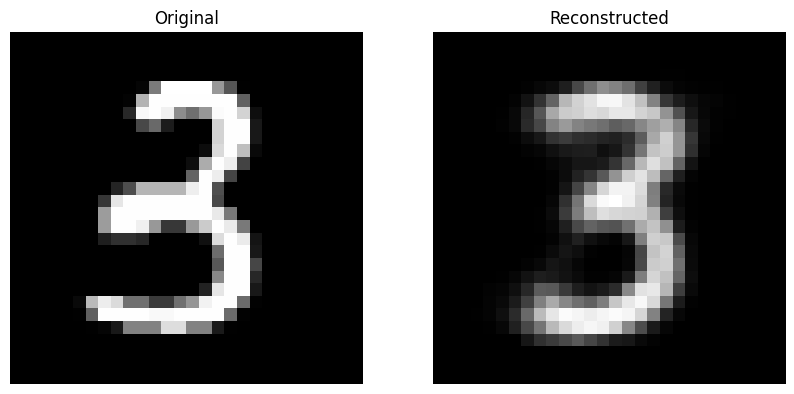

Epoch [4/10], Train Loss: 0.0310, Val Loss: 0.0298, Val SSIM: 0.6966


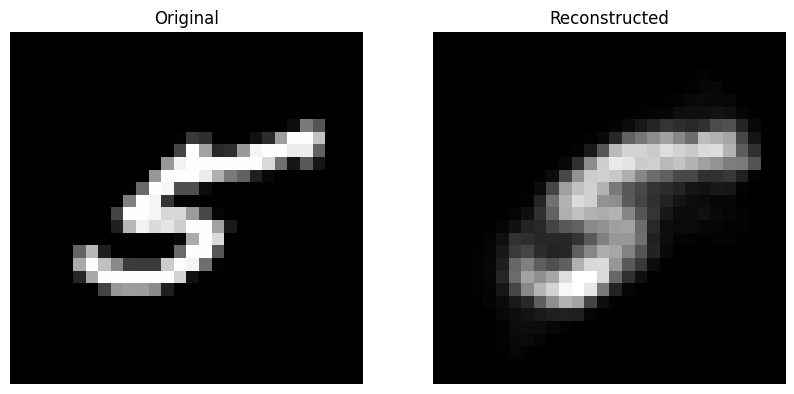

Epoch [5/10], Train Loss: 0.0289, Val Loss: 0.0278, Val SSIM: 0.7141


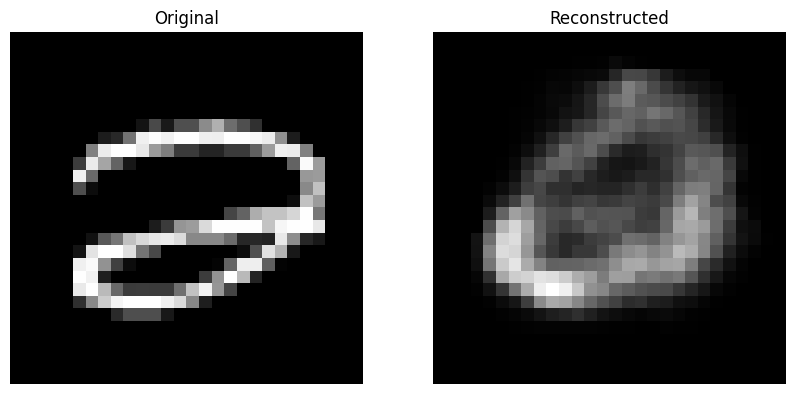

Epoch [6/10], Train Loss: 0.0267, Val Loss: 0.0260, Val SSIM: 0.7336


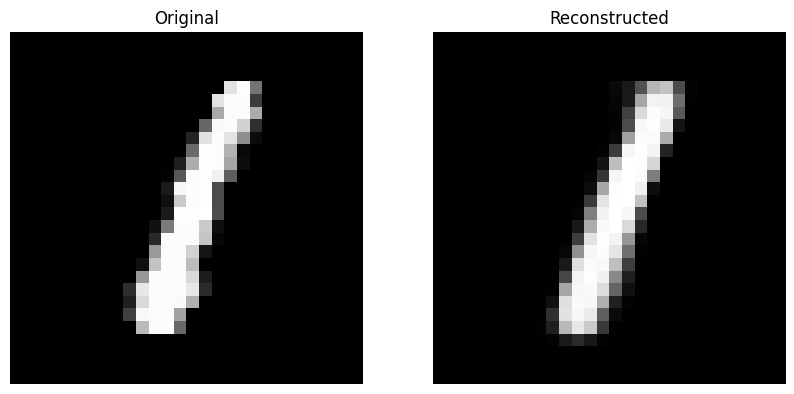

Epoch [7/10], Train Loss: 0.0254, Val Loss: 0.0249, Val SSIM: 0.7472


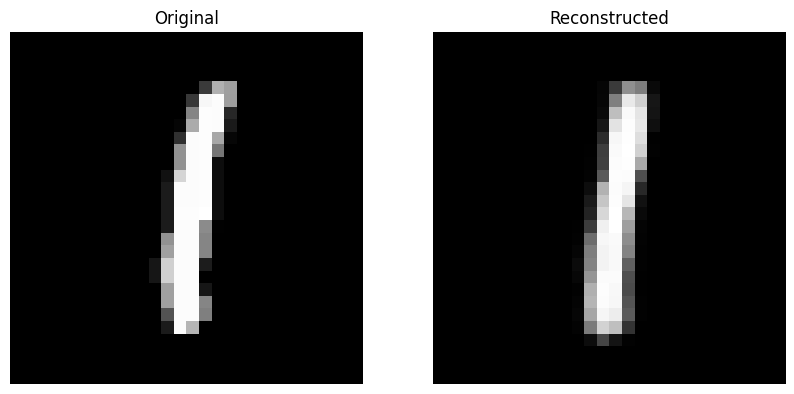

Epoch [8/10], Train Loss: 0.0244, Val Loss: 0.0244, Val SSIM: 0.7532


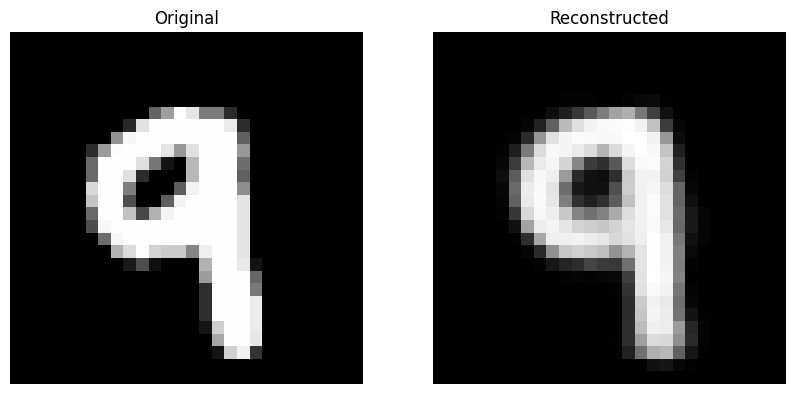

Epoch [9/10], Train Loss: 0.0237, Val Loss: 0.0236, Val SSIM: 0.7633


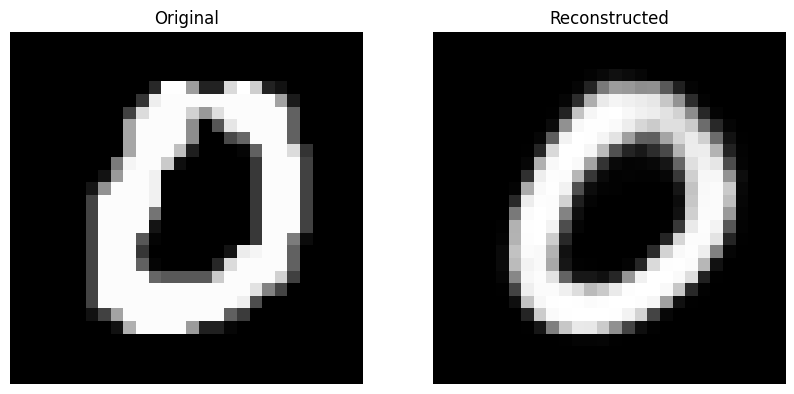

Epoch [10/10], Train Loss: 0.0229, Val Loss: 0.0229, Val SSIM: 0.7682
Training finished.


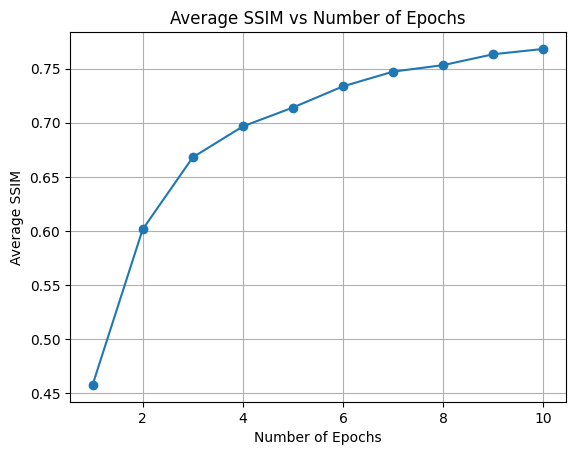

In [34]:
num_epochs = 10
avg_ssim_values = train_model(model,num_epochs,train_loader,val_loader,optimizer,criterion,0,0)
# Plotting
epochs = range(1, num_epochs + 1)
plt.plot(epochs, avg_ssim_values, marker='o', linestyle='-')
plt.xlabel('Number of Epochs')
plt.ylabel('Average SSIM')
plt.title('Average SSIM vs Number of Epochs')
plt.grid(True)
plt.show()

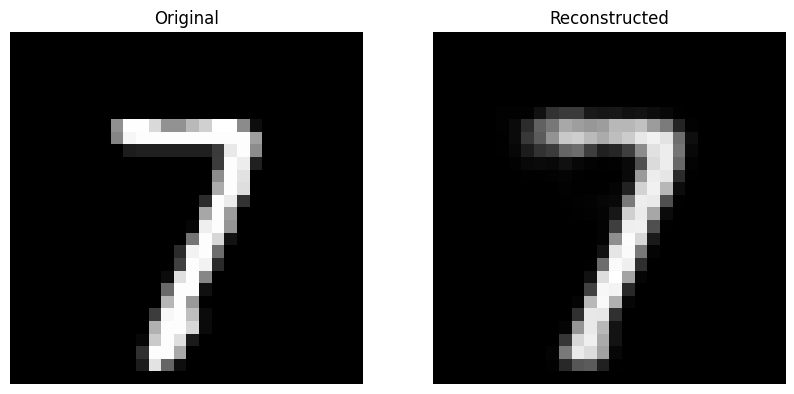

Final Reconstruction Loss: 0.0226, Final SSIM Score: 0.7708


In [35]:
final_loss, final_ssim_score = evaluate_model(model, test_loader, criterion)
print(f"Final Reconstruction Loss: {final_loss:.4f}, Final SSIM Score: {final_ssim_score:.4f}")


*************************************************************************************************************************

SIGMA VALUE  0.1


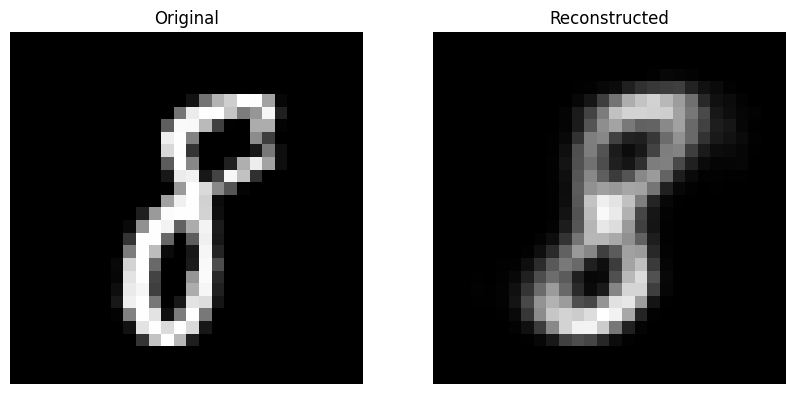

Epoch [1/10], Train Loss: 0.0419, Val Loss: 0.0242, Val SSIM: 0.7476


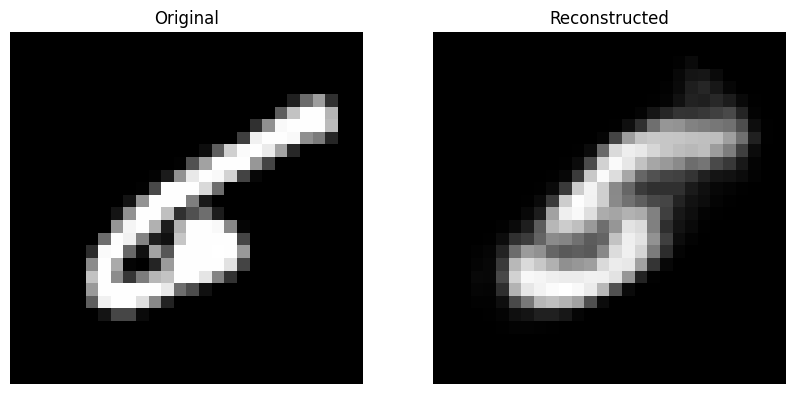

Epoch [2/10], Train Loss: 0.0328, Val Loss: 0.0218, Val SSIM: 0.7760


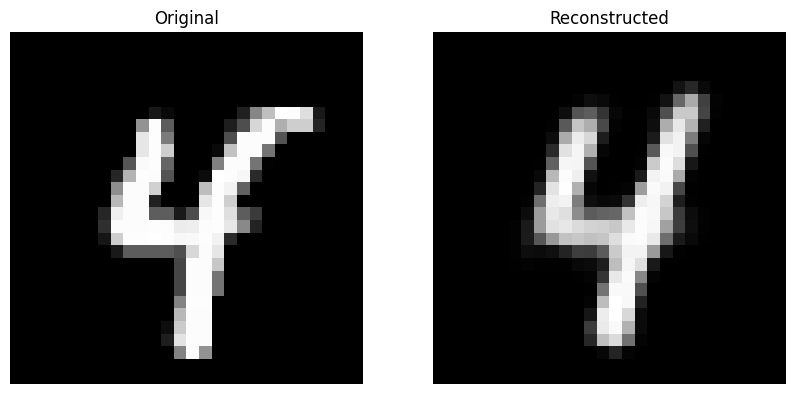

Epoch [3/10], Train Loss: 0.0311, Val Loss: 0.0204, Val SSIM: 0.7914


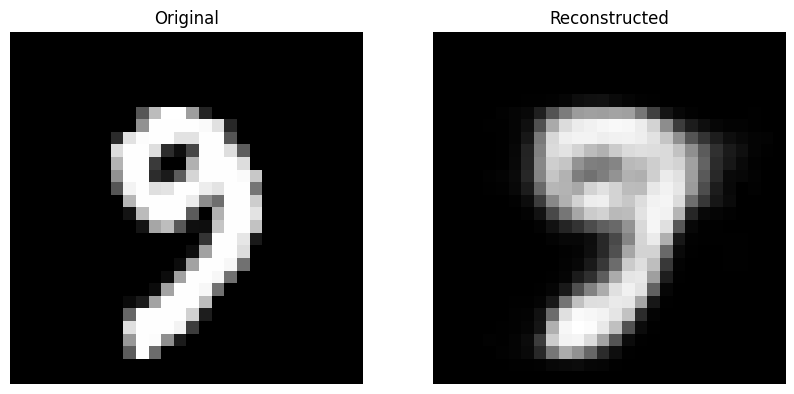

Epoch [4/10], Train Loss: 0.0299, Val Loss: 0.0197, Val SSIM: 0.7995


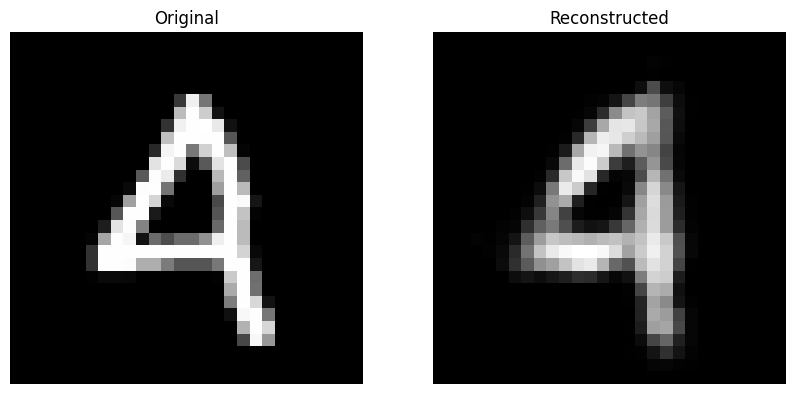

Epoch [5/10], Train Loss: 0.0292, Val Loss: 0.0190, Val SSIM: 0.8064


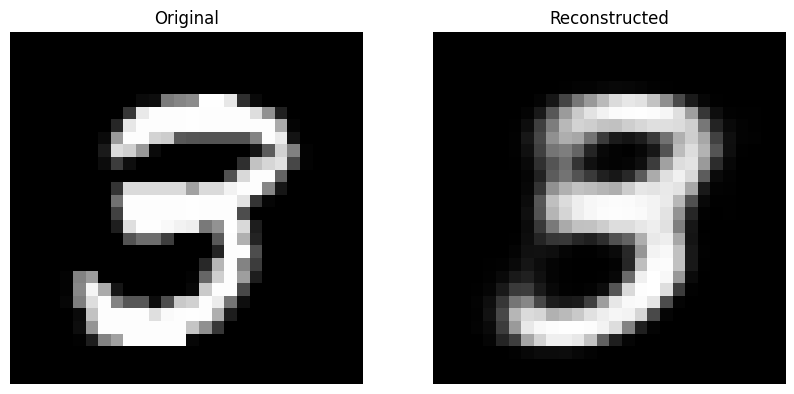

Epoch [6/10], Train Loss: 0.0286, Val Loss: 0.0184, Val SSIM: 0.8140


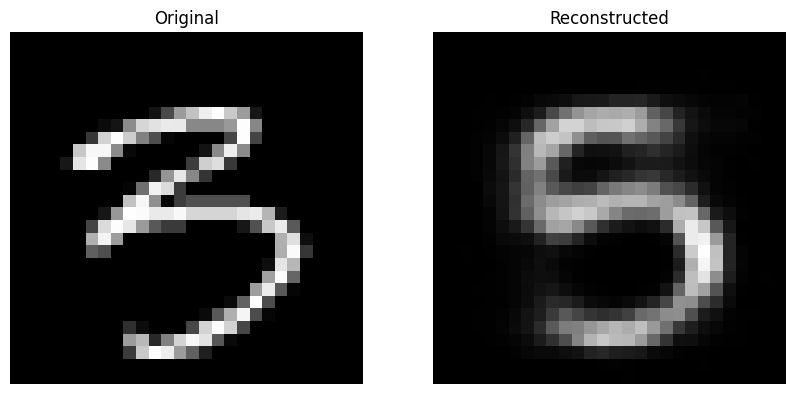

Epoch [7/10], Train Loss: 0.0281, Val Loss: 0.0181, Val SSIM: 0.8169


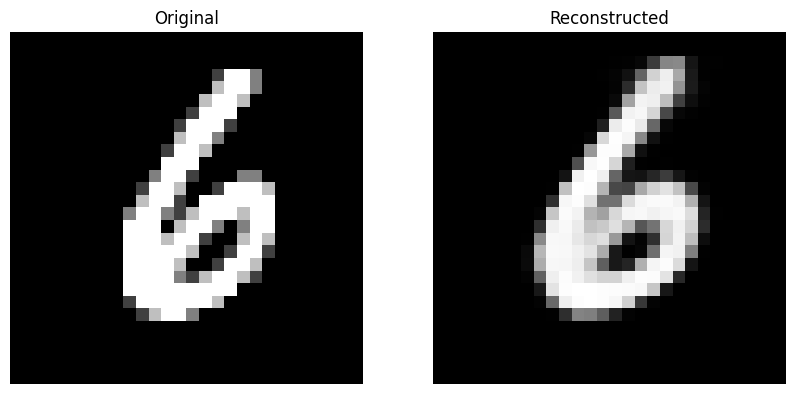

Epoch [8/10], Train Loss: 0.0277, Val Loss: 0.0176, Val SSIM: 0.8218


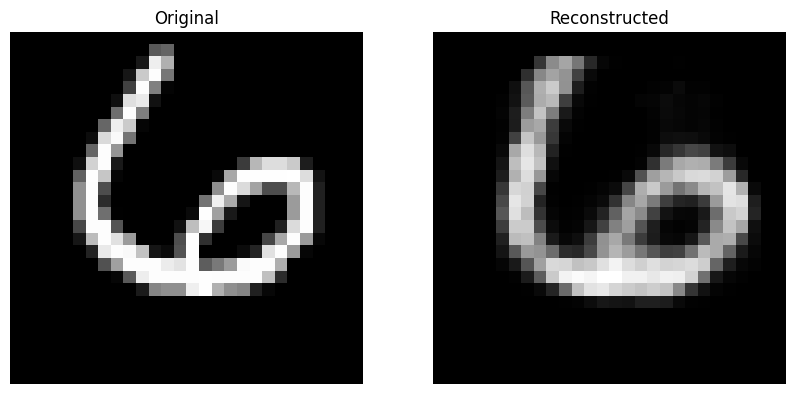

Epoch [9/10], Train Loss: 0.0273, Val Loss: 0.0173, Val SSIM: 0.8254


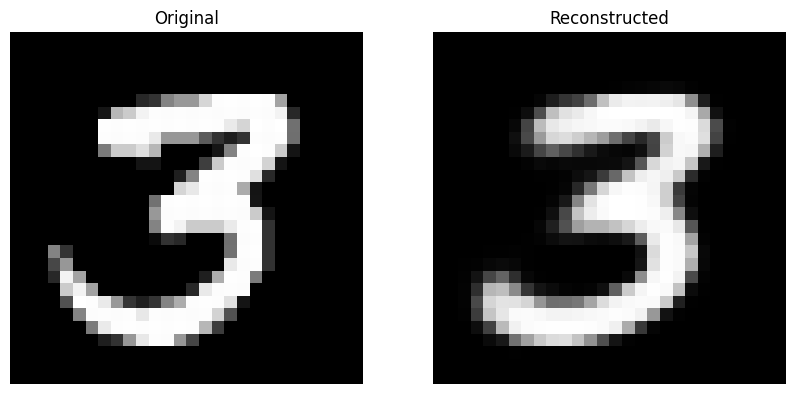

Epoch [10/10], Train Loss: 0.0270, Val Loss: 0.0170, Val SSIM: 0.8276
Training finished.


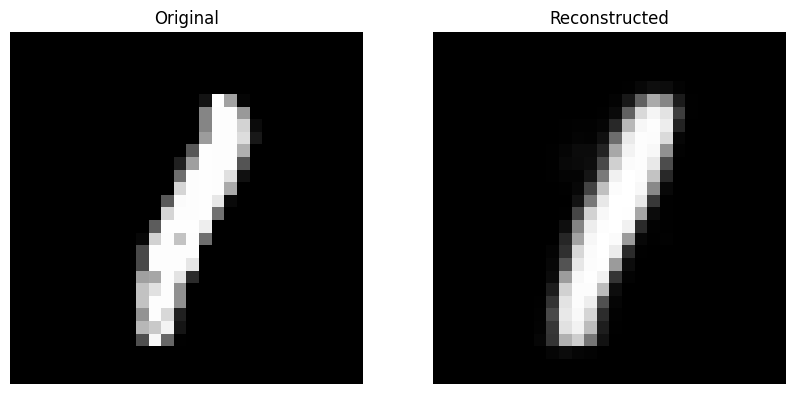

Sigma 0.1 completed, SSIM was 0.8301409278371761
*************************************************************************************************************************

SIGMA VALUE  3


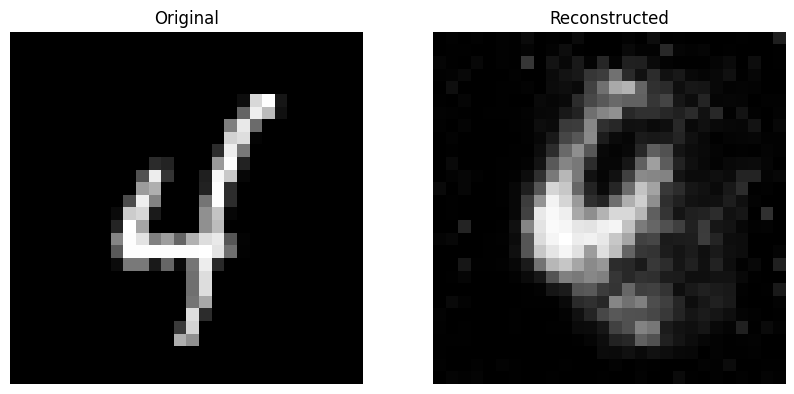

Epoch [1/10], Train Loss: 8.9902, Val Loss: 0.0457, Val SSIM: 0.4878


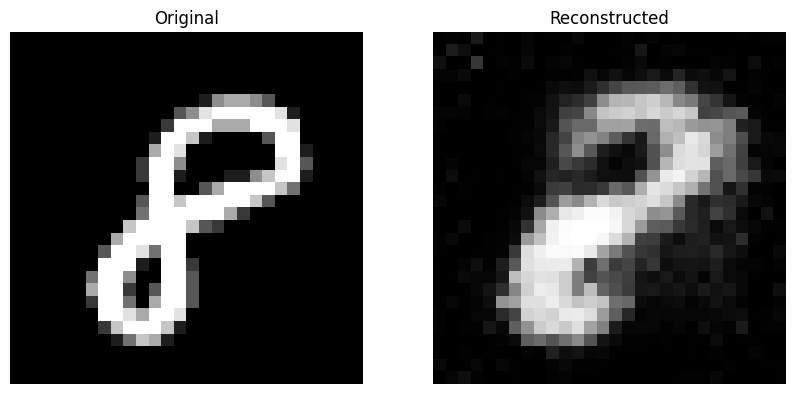

Epoch [2/10], Train Loss: 8.9650, Val Loss: 0.0431, Val SSIM: 0.5277


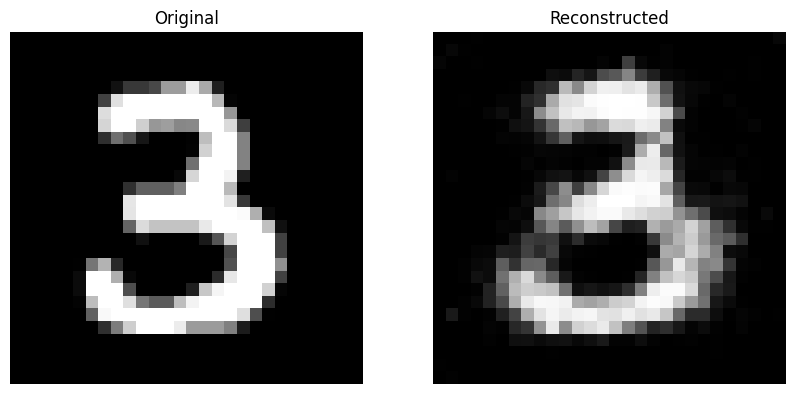

Epoch [3/10], Train Loss: 8.9641, Val Loss: 0.0453, Val SSIM: 0.5389


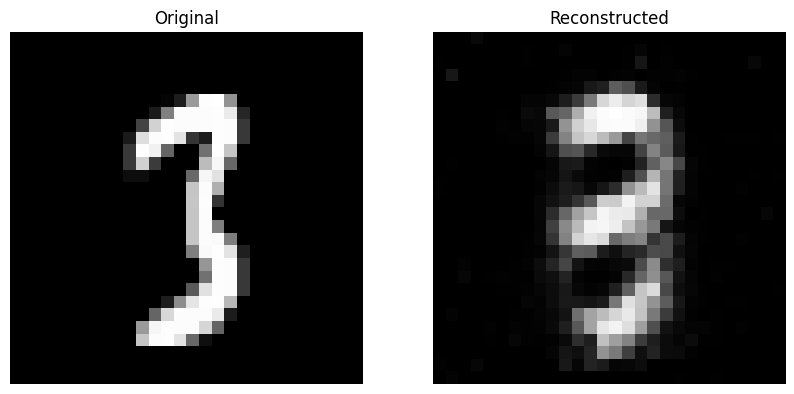

Epoch [4/10], Train Loss: 8.9530, Val Loss: 0.0443, Val SSIM: 0.5592


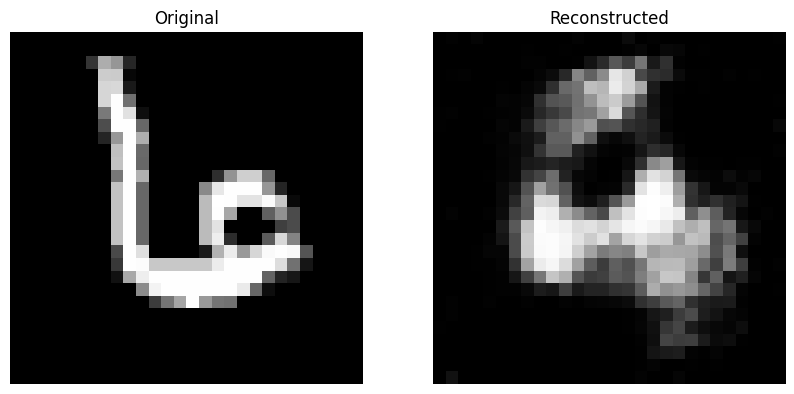

Epoch [5/10], Train Loss: 8.9505, Val Loss: 0.0425, Val SSIM: 0.5751


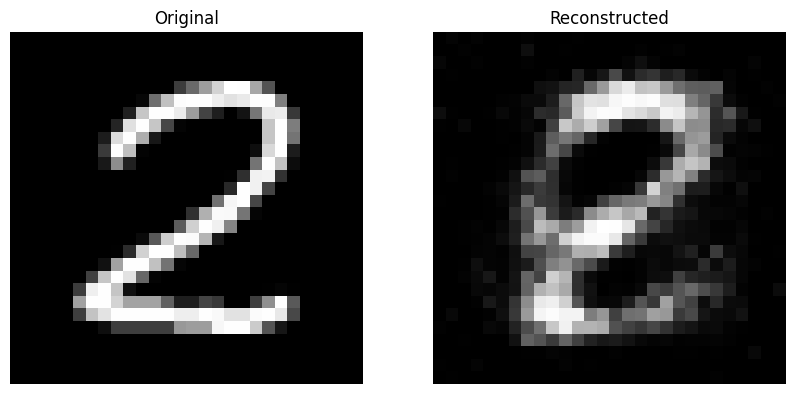

Epoch [6/10], Train Loss: 8.9472, Val Loss: 0.0429, Val SSIM: 0.5838


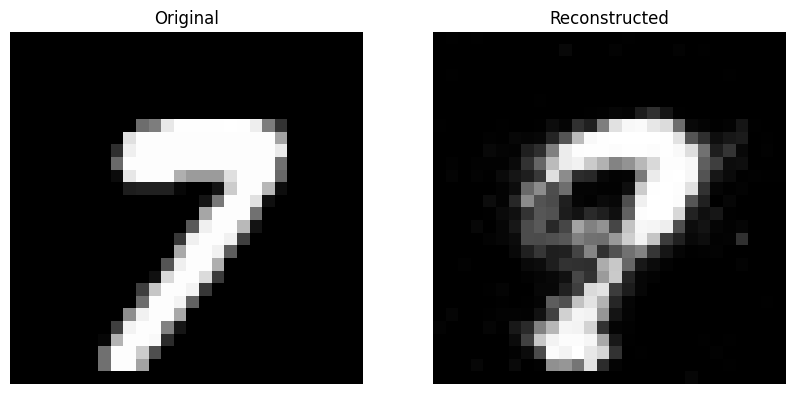

Epoch [7/10], Train Loss: 8.9417, Val Loss: 0.0429, Val SSIM: 0.5919


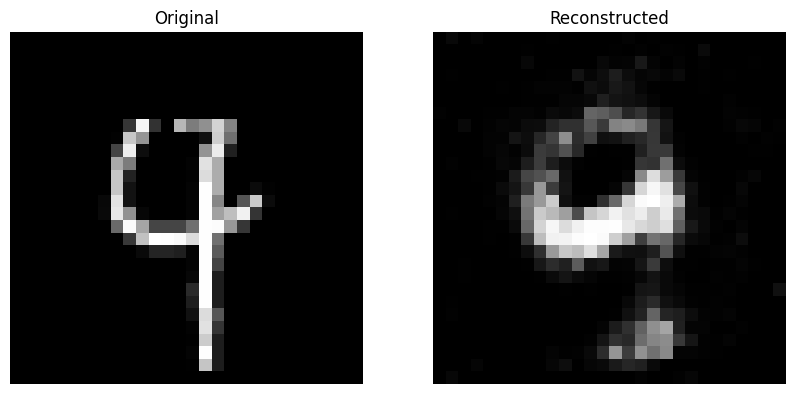

Epoch [8/10], Train Loss: 8.9416, Val Loss: 0.0408, Val SSIM: 0.5972


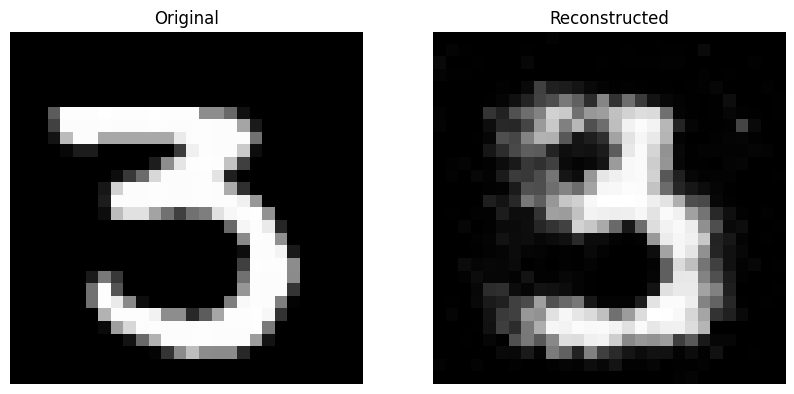

Epoch [9/10], Train Loss: 8.9408, Val Loss: 0.0398, Val SSIM: 0.6063


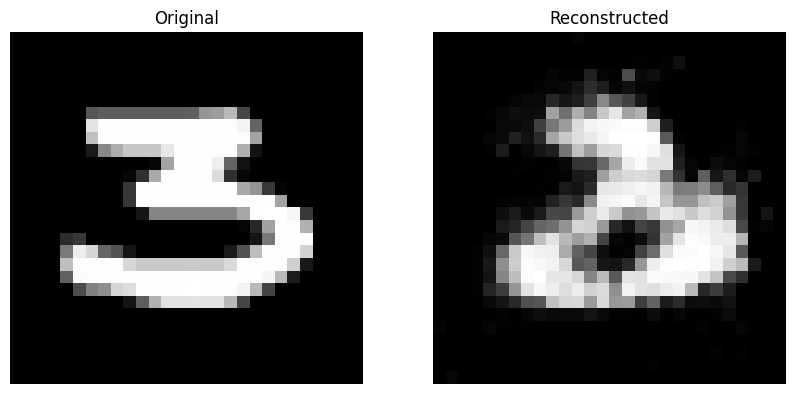

Epoch [10/10], Train Loss: 8.9372, Val Loss: 0.0421, Val SSIM: 0.6051
Training finished.


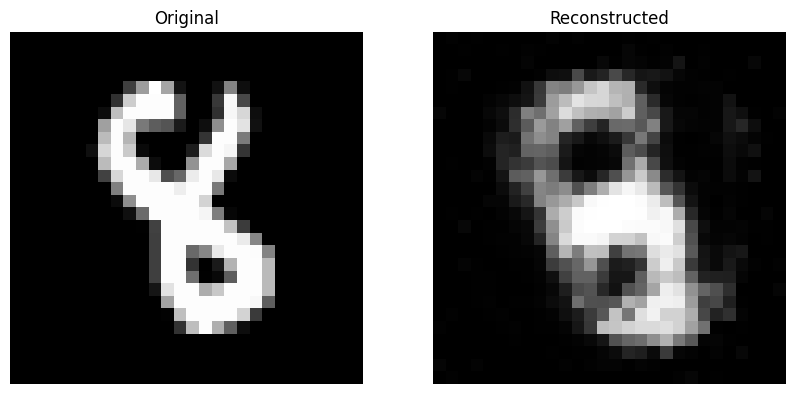

Sigma 3 completed, SSIM was 0.6093822337241396
*************************************************************************************************************************

SIGMA VALUE  10


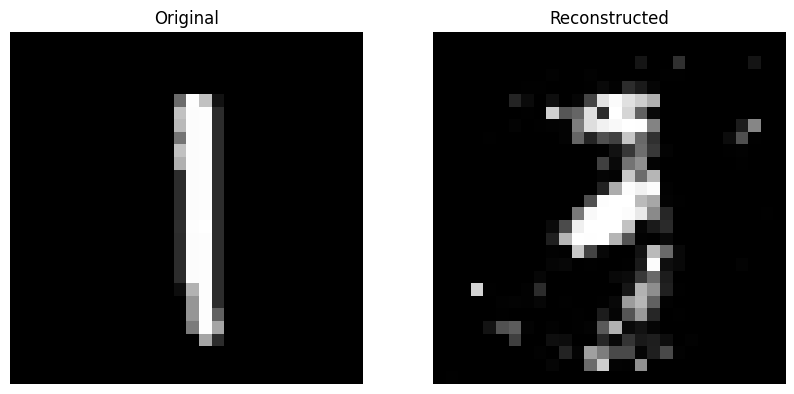

Epoch [1/10], Train Loss: 99.6114, Val Loss: 0.0860, Val SSIM: 0.4325


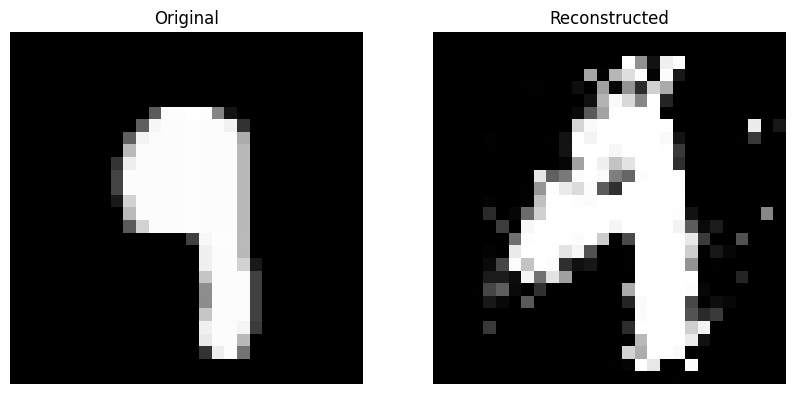

Epoch [2/10], Train Loss: 99.5378, Val Loss: 0.1023, Val SSIM: 0.3933


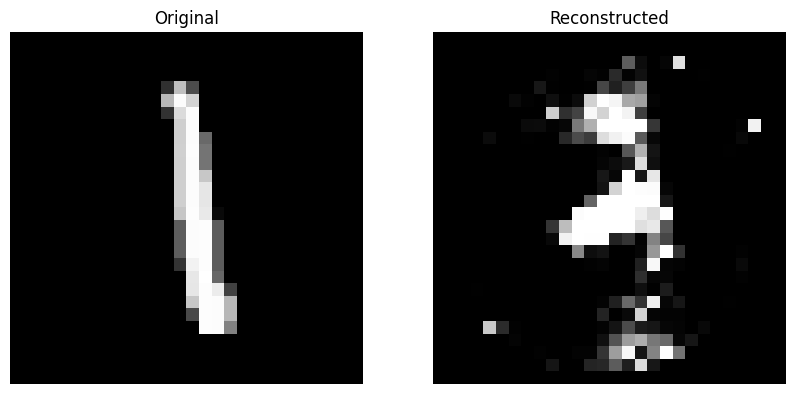

Epoch [3/10], Train Loss: 99.4910, Val Loss: 0.0916, Val SSIM: 0.4303


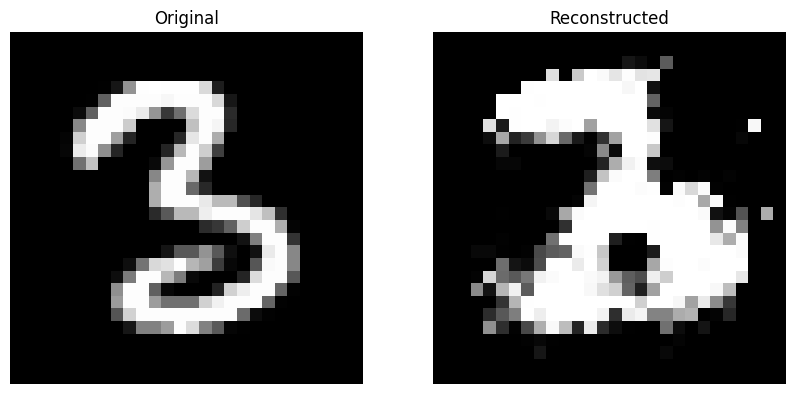

Epoch [4/10], Train Loss: 99.5262, Val Loss: 0.1011, Val SSIM: 0.4002


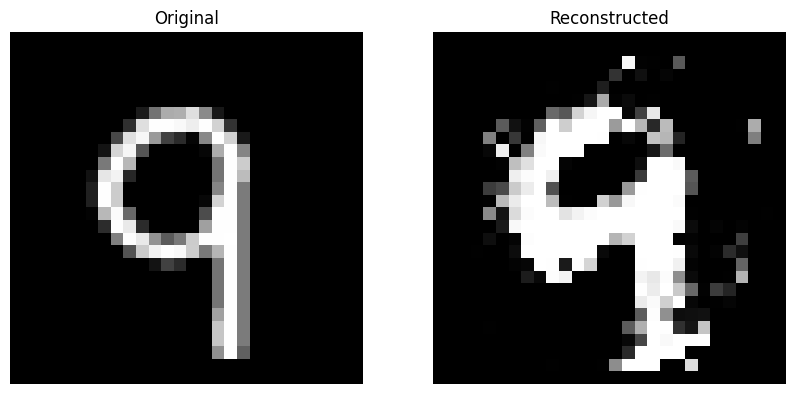

Epoch [5/10], Train Loss: 99.5682, Val Loss: 0.0957, Val SSIM: 0.4367


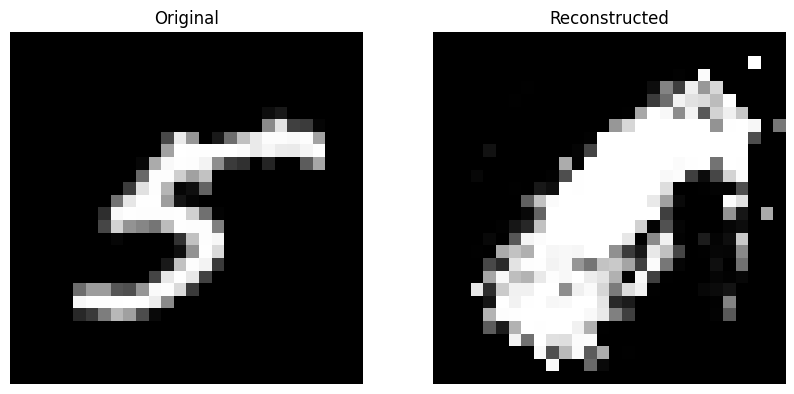

Epoch [6/10], Train Loss: 99.5089, Val Loss: 0.1064, Val SSIM: 0.3969


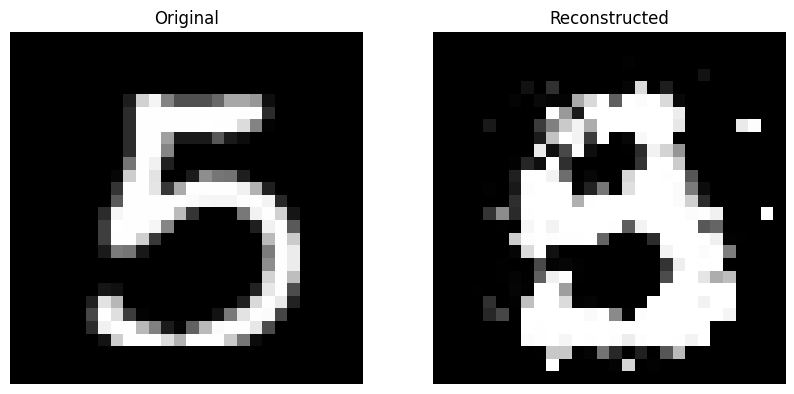

Epoch [7/10], Train Loss: 99.5452, Val Loss: 0.1174, Val SSIM: 0.3617


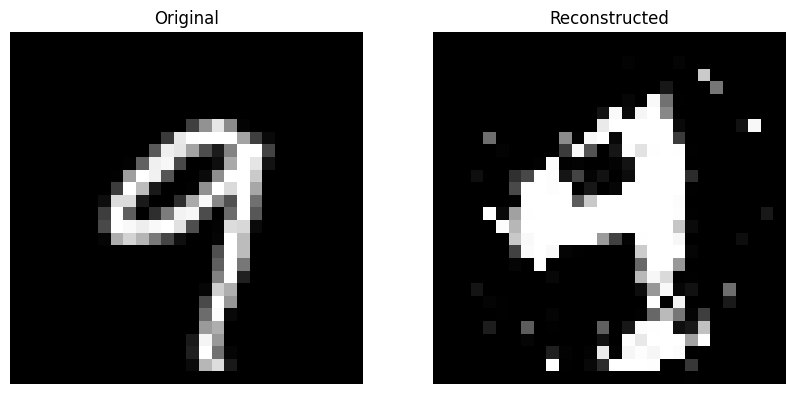

Epoch [8/10], Train Loss: 99.5626, Val Loss: 0.1189, Val SSIM: 0.3698


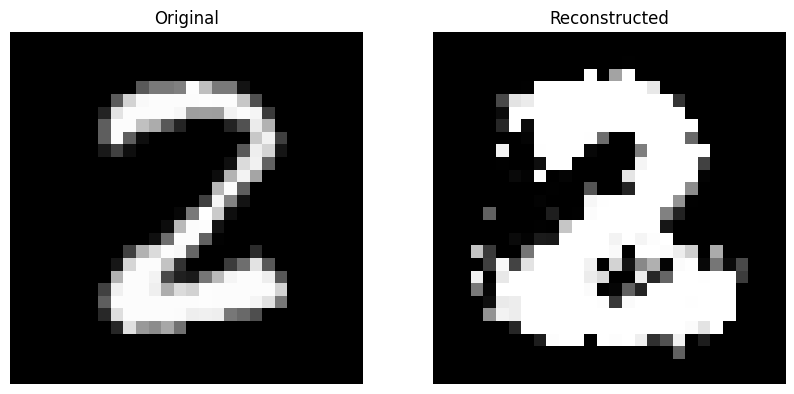

Epoch [9/10], Train Loss: 99.5137, Val Loss: 0.1437, Val SSIM: 0.3075


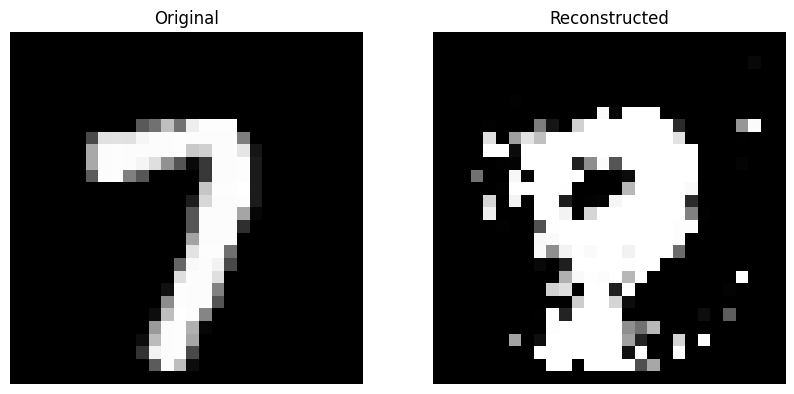

Epoch [10/10], Train Loss: 99.5446, Val Loss: 0.1161, Val SSIM: 0.3931
Training finished.


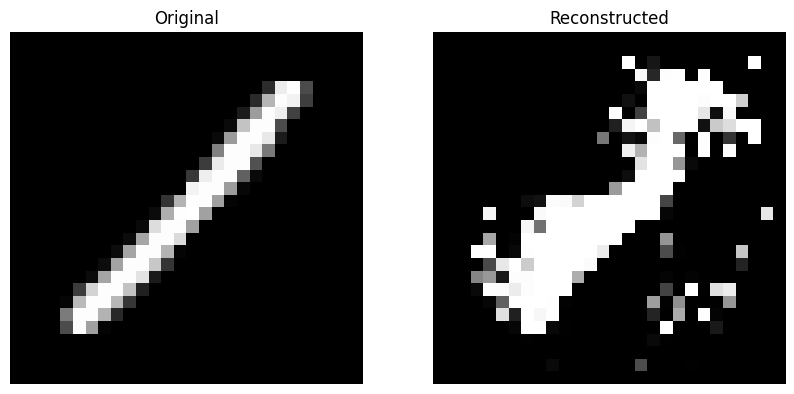

Sigma 10 completed, SSIM was 0.39596780099258533


In [38]:
# Define sigma values to test
sigma_values = [0.1,3,10]
avg_ssim_scores = []
avg_loss = []

# Train and evaluate the model for each sigma value
for sigma in sigma_values:
    print("*************************************************************************************************************************\n")
    print("SIGMA VALUE ", sigma)
    train_model(model, 10, train_loader, val_loader, optimizer, criterion, sigma, 1)
    loss, avg_ssim = evaluate_model(model, test_loader, criterion)
    avg_ssim_scores.append(avg_ssim)
    avg_loss.append(loss)
    print("Sigma", sigma, "completed, SSIM was", avg_ssim)


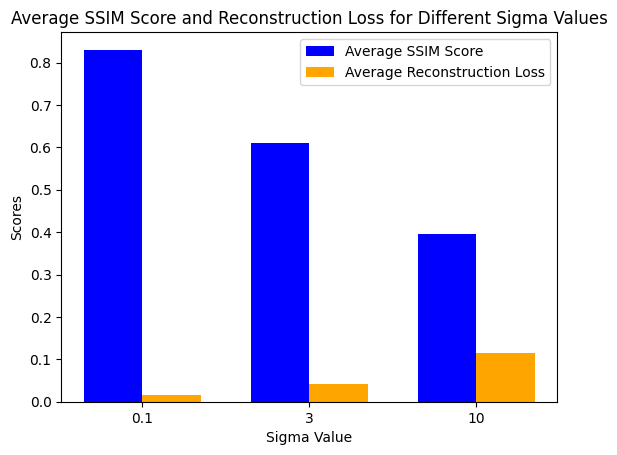

In [39]:
bar_width = 0.35
index = range(len(sigma_values))
fig, ax = plt.subplots()
bar1 = ax.bar(index, avg_ssim_scores, bar_width, label='Average SSIM Score', color='blue')
bar2 = ax.bar([i + bar_width for i in index], avg_loss, bar_width, label='Average Reconstruction Loss', color='orange')

# Add labels and title
ax.set_xlabel('Sigma Value')
ax.set_ylabel('Scores')
ax.set_title('Average SSIM Score and Reconstruction Loss for Different Sigma Values')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(sigma_values)
ax.legend()

# Show plot
plt.show()

In [40]:
import torch

class AutoEncoder2(torch.nn.Module):
    def __init__(self, bottleneck_size) -> None:
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28*28, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, bottleneck_size),
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(bottleneck_size, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 28*28),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


******************************************************************

BOTTLENECK: 1


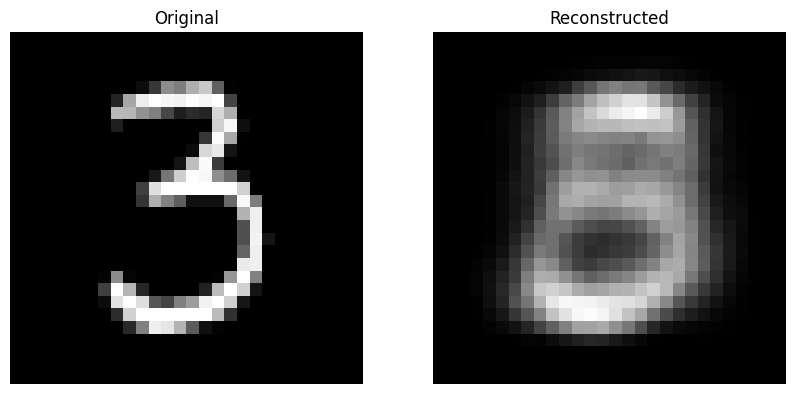

Epoch [1/10], Train Loss: 0.0671, Val Loss: 0.0555, Val SSIM: 0.3864


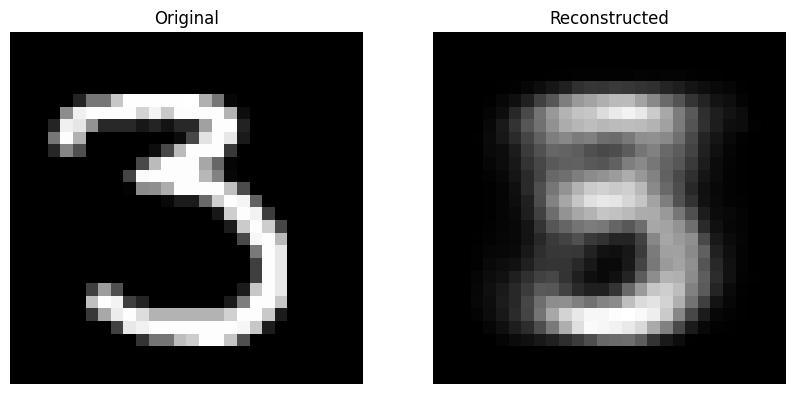

Epoch [2/10], Train Loss: 0.0558, Val Loss: 0.0522, Val SSIM: 0.4245


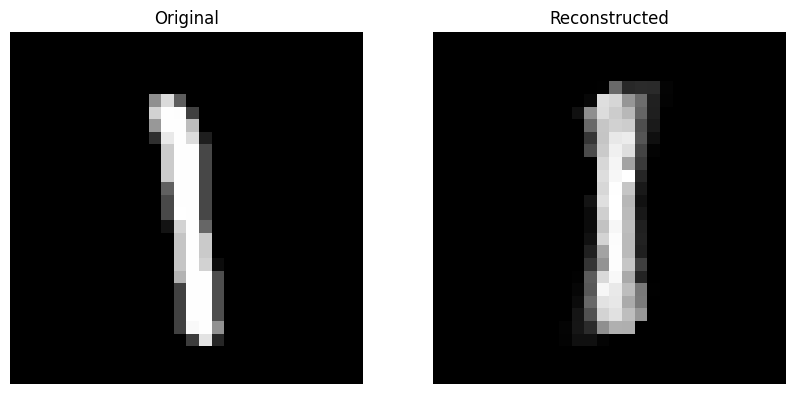

Epoch [3/10], Train Loss: 0.0530, Val Loss: 0.0497, Val SSIM: 0.4543


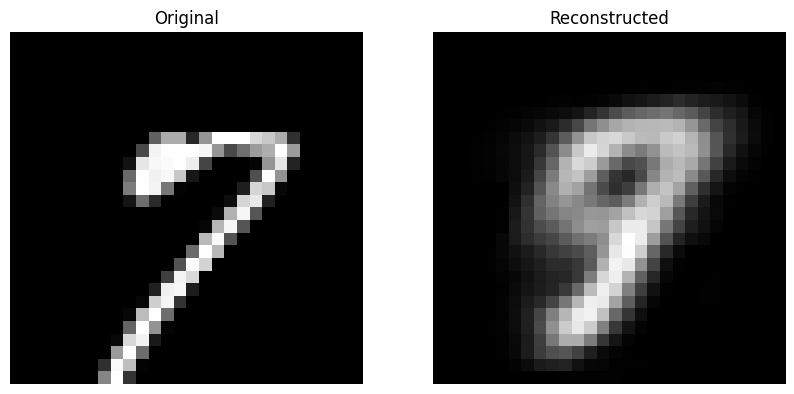

Epoch [4/10], Train Loss: 0.0521, Val Loss: 0.0494, Val SSIM: 0.4703


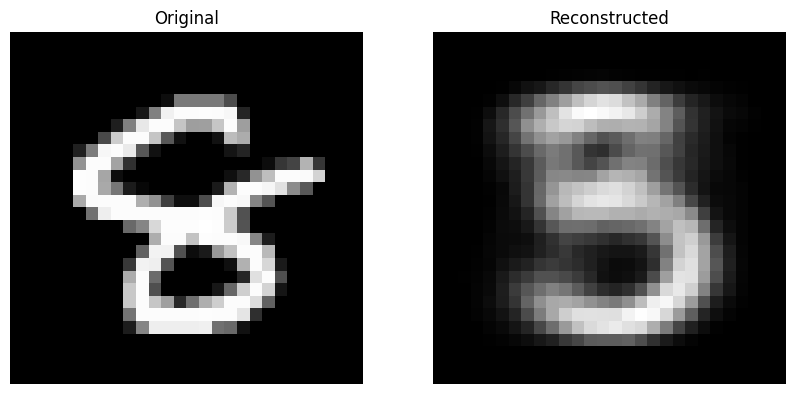

Epoch [5/10], Train Loss: 0.0512, Val Loss: 0.0485, Val SSIM: 0.4815


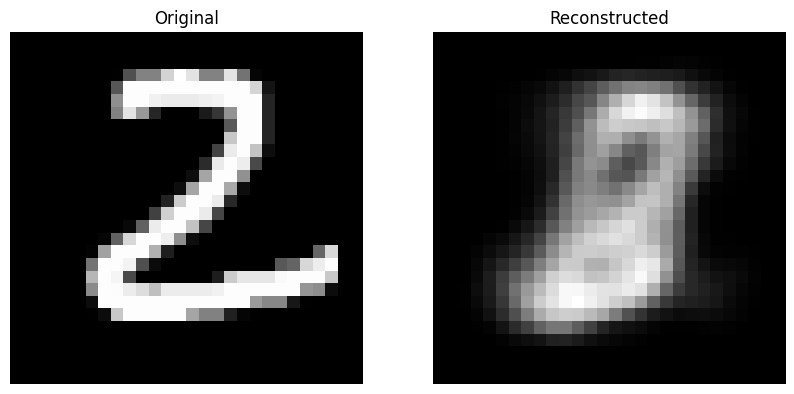

Epoch [6/10], Train Loss: 0.0510, Val Loss: 0.0479, Val SSIM: 0.4897


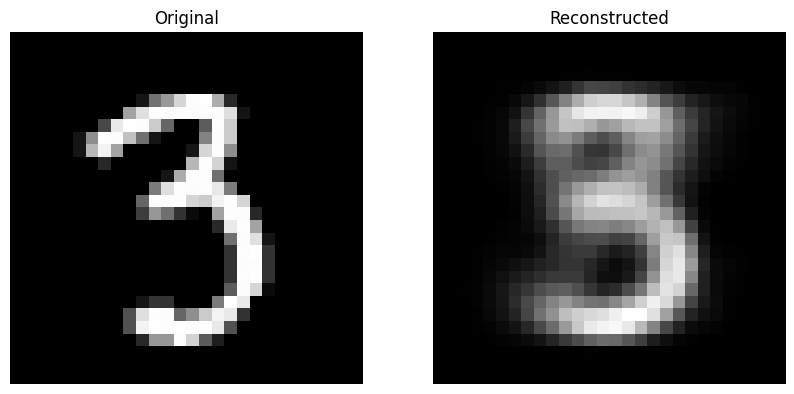

Epoch [7/10], Train Loss: 0.0503, Val Loss: 0.0473, Val SSIM: 0.4928


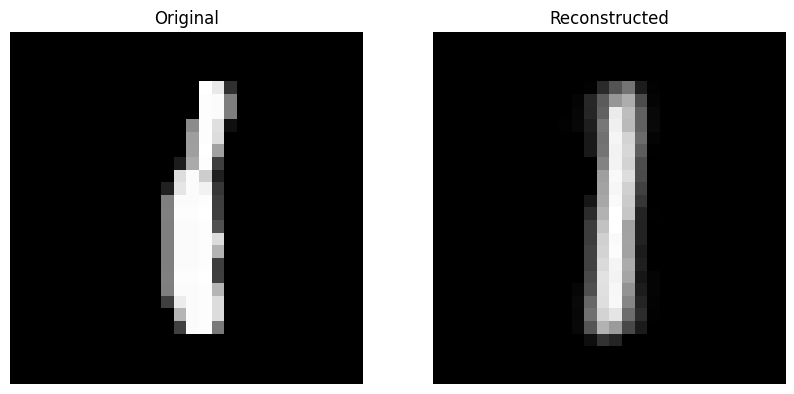

Epoch [8/10], Train Loss: 0.0497, Val Loss: 0.0468, Val SSIM: 0.4976


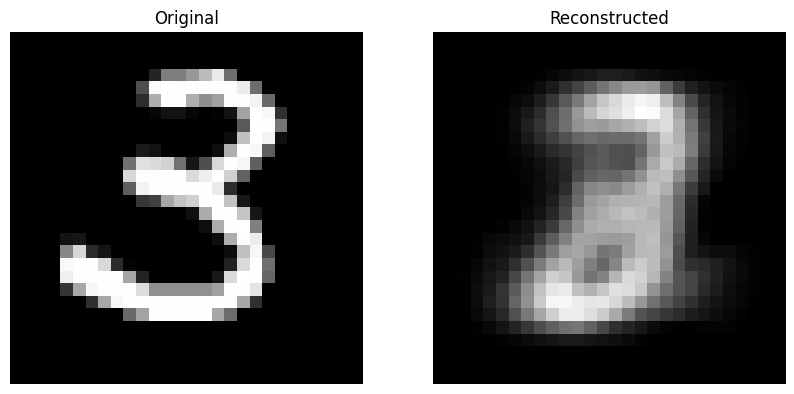

Epoch [9/10], Train Loss: 0.0494, Val Loss: 0.0477, Val SSIM: 0.4984


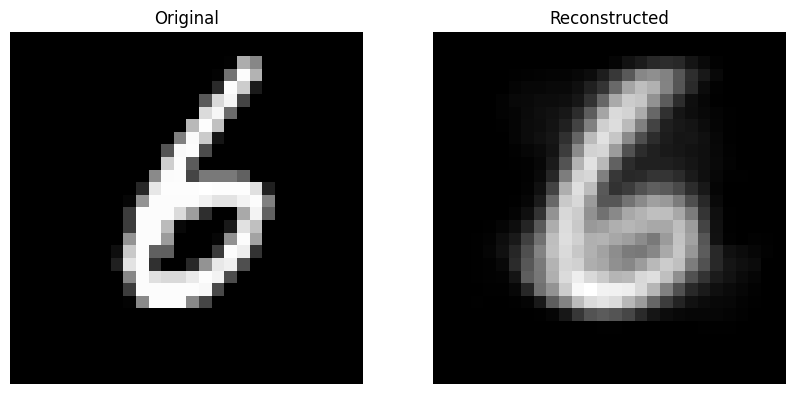

Epoch [10/10], Train Loss: 0.0499, Val Loss: 0.0462, Val SSIM: 0.5068
Training finished.


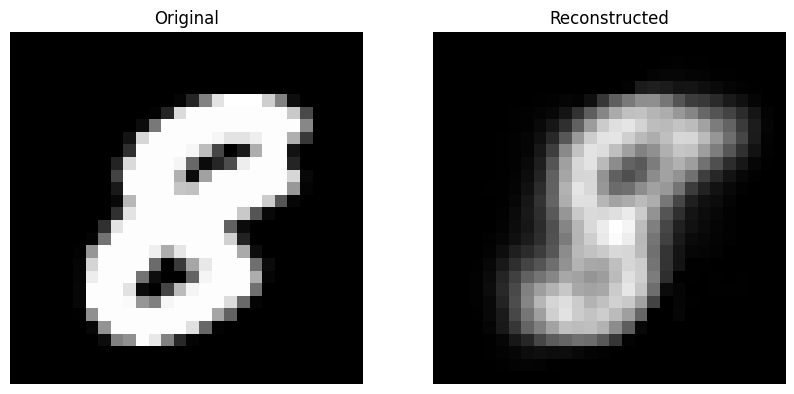

bottleneck value completed 1 avg ssim 0.5091380330401442
******************************************************************

BOTTLENECK: 16


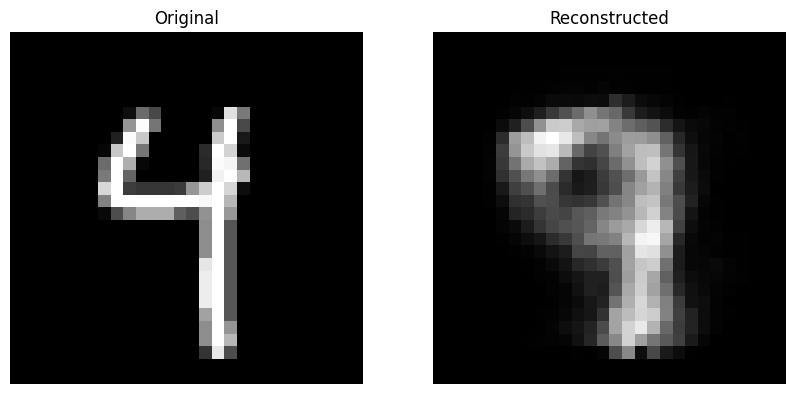

Epoch [1/10], Train Loss: 0.0630, Val Loss: 0.0423, Val SSIM: 0.5526


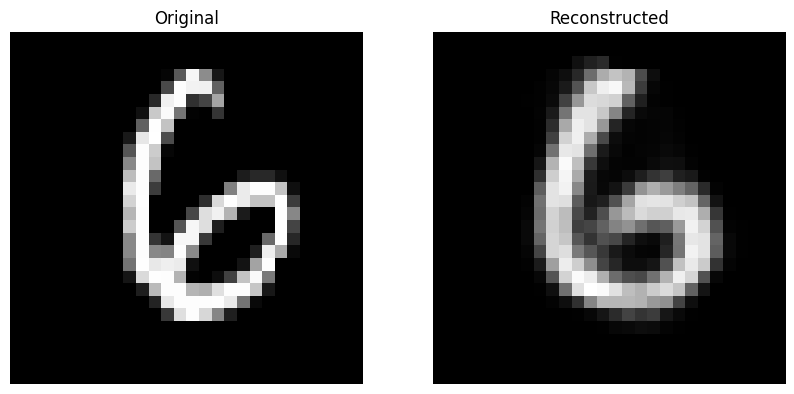

Epoch [2/10], Train Loss: 0.0360, Val Loss: 0.0291, Val SSIM: 0.6991


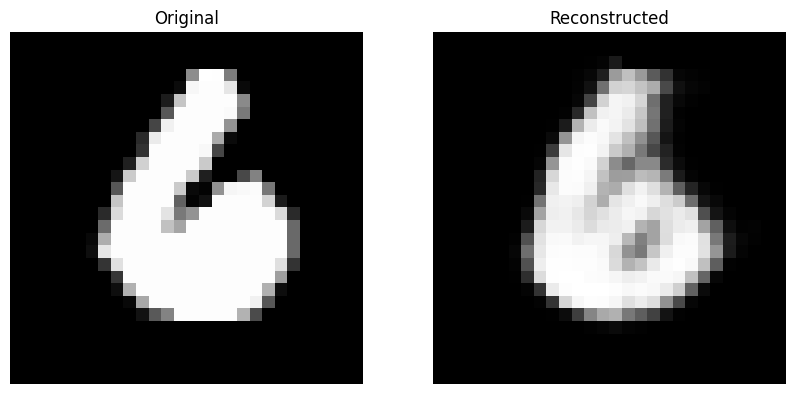

Epoch [3/10], Train Loss: 0.0296, Val Loss: 0.0255, Val SSIM: 0.7383


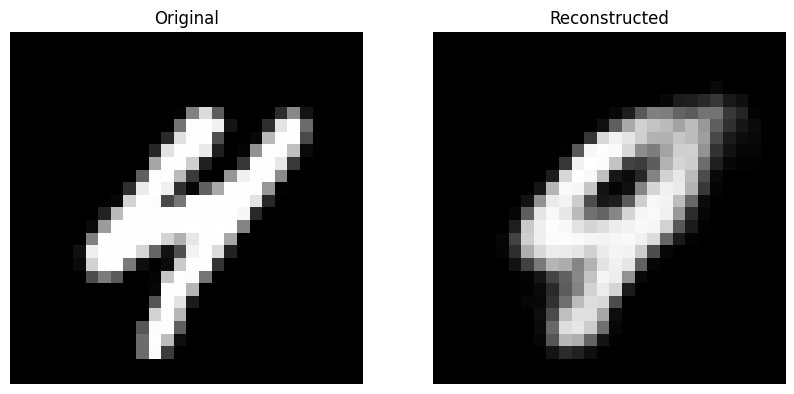

Epoch [4/10], Train Loss: 0.0265, Val Loss: 0.0228, Val SSIM: 0.7641


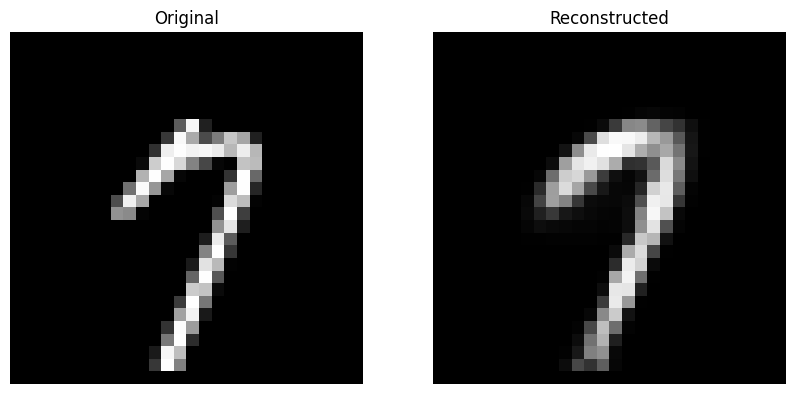

Epoch [5/10], Train Loss: 0.0243, Val Loss: 0.0209, Val SSIM: 0.7853


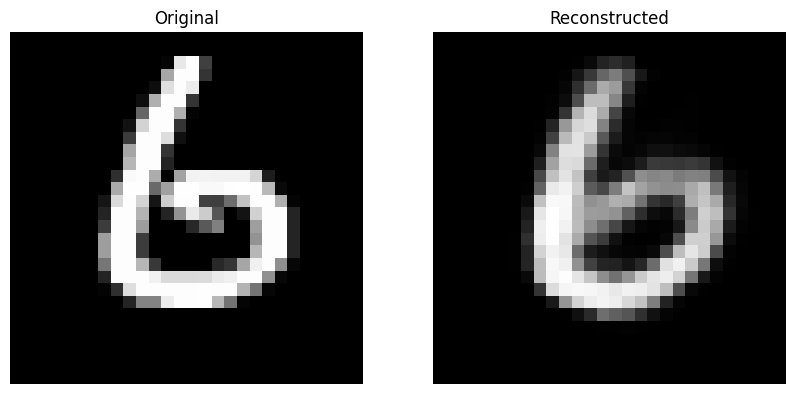

Epoch [6/10], Train Loss: 0.0226, Val Loss: 0.0192, Val SSIM: 0.8054


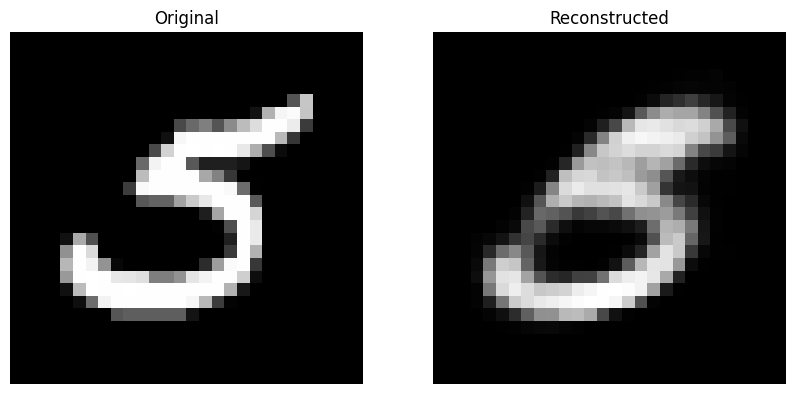

Epoch [7/10], Train Loss: 0.0210, Val Loss: 0.0178, Val SSIM: 0.8191


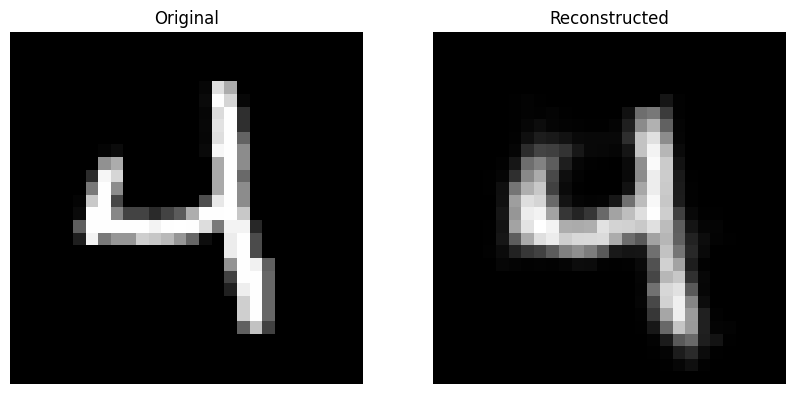

Epoch [8/10], Train Loss: 0.0199, Val Loss: 0.0170, Val SSIM: 0.8281


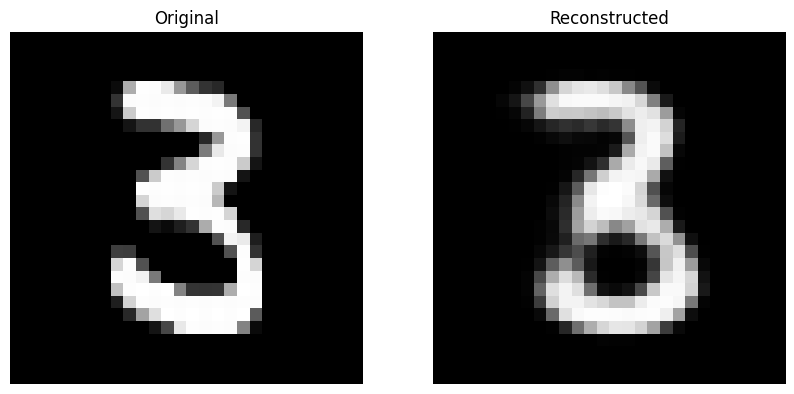

Epoch [9/10], Train Loss: 0.0191, Val Loss: 0.0164, Val SSIM: 0.8364


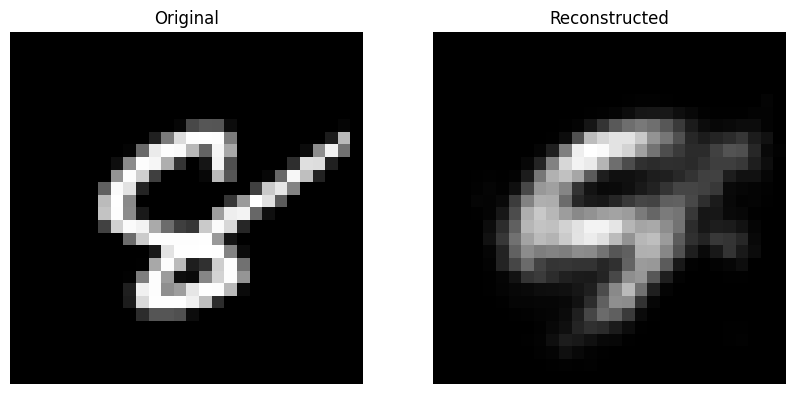

Epoch [10/10], Train Loss: 0.0184, Val Loss: 0.0157, Val SSIM: 0.8429
Training finished.


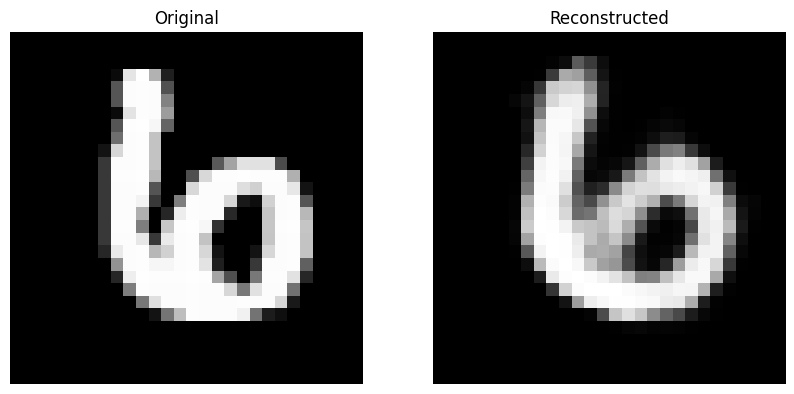

bottleneck value completed 16 avg ssim 0.8459339721002214
******************************************************************

BOTTLENECK: 32


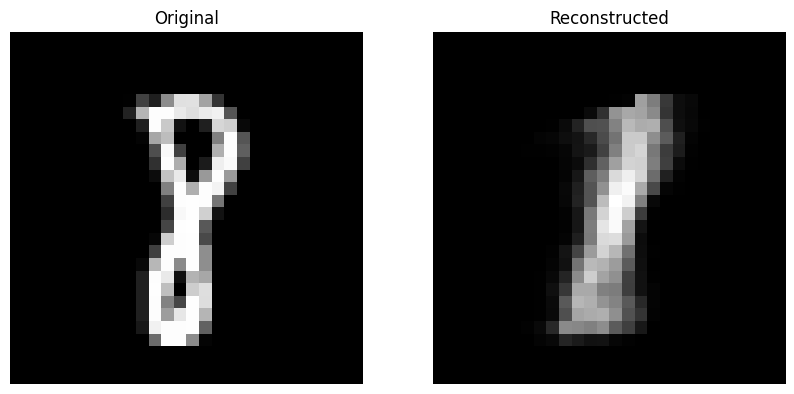

Epoch [1/10], Train Loss: 0.0639, Val Loss: 0.0415, Val SSIM: 0.5658


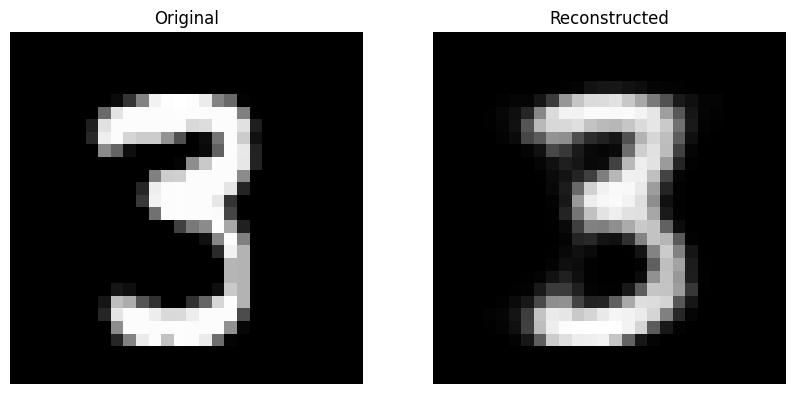

Epoch [2/10], Train Loss: 0.0353, Val Loss: 0.0283, Val SSIM: 0.7092


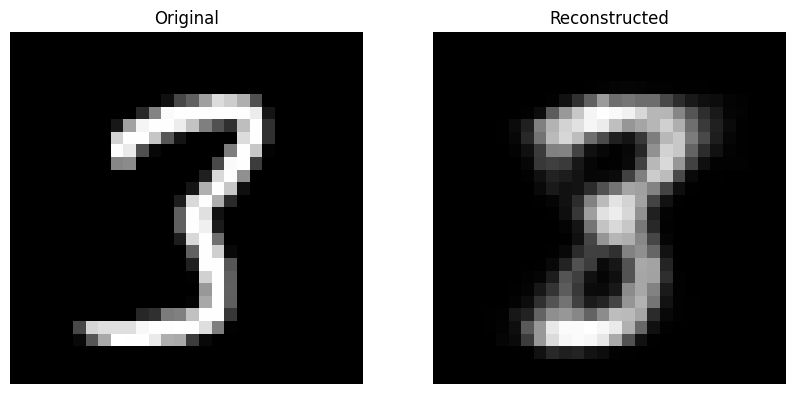

Epoch [3/10], Train Loss: 0.0290, Val Loss: 0.0252, Val SSIM: 0.7385


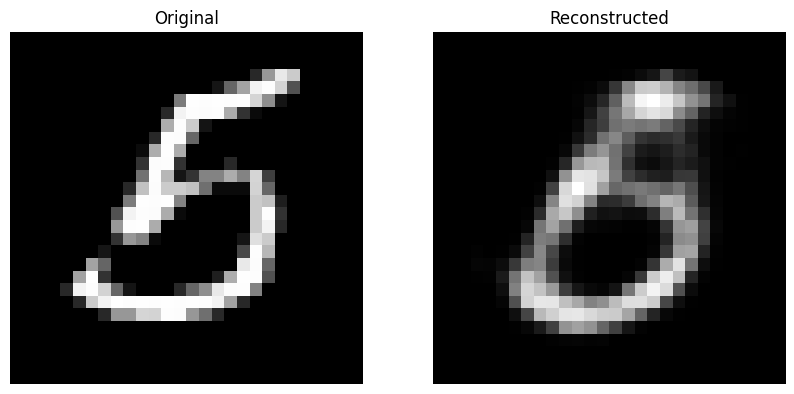

Epoch [4/10], Train Loss: 0.0260, Val Loss: 0.0223, Val SSIM: 0.7749


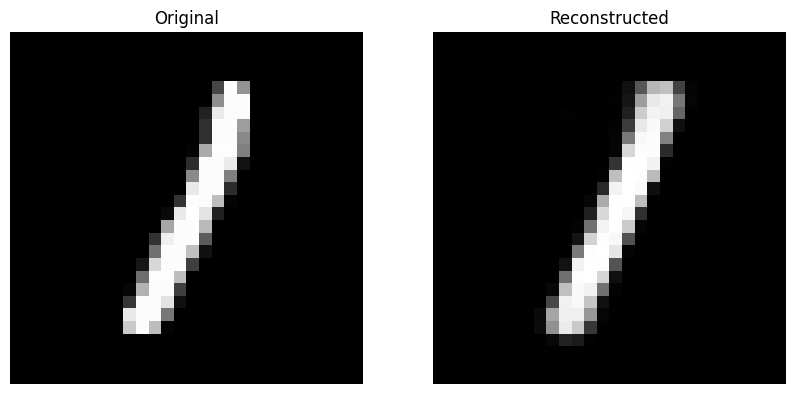

Epoch [5/10], Train Loss: 0.0234, Val Loss: 0.0199, Val SSIM: 0.7975


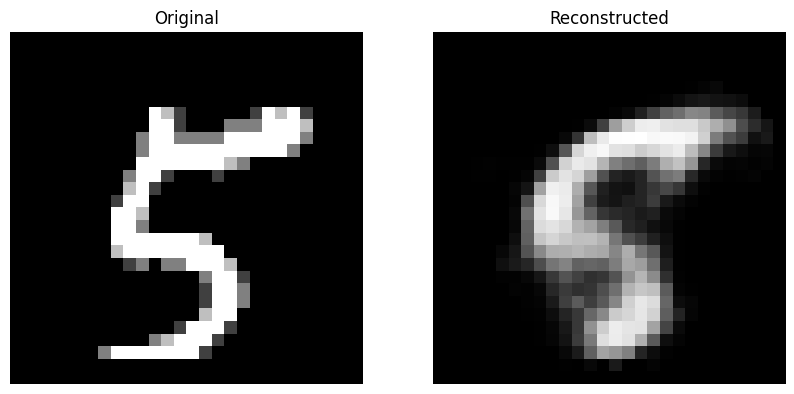

Epoch [6/10], Train Loss: 0.0216, Val Loss: 0.0185, Val SSIM: 0.8124


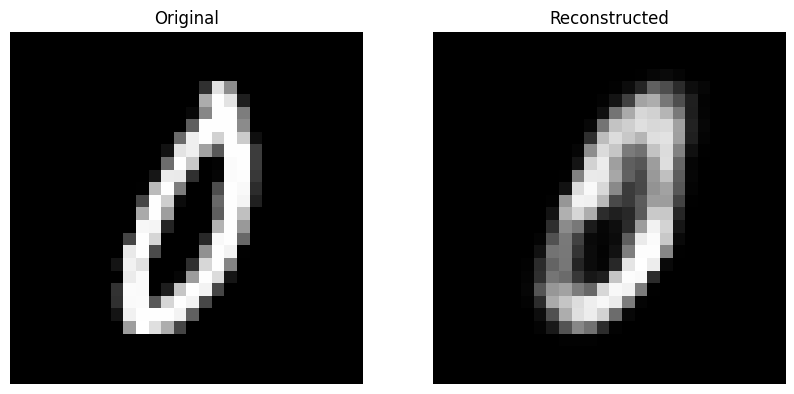

Epoch [7/10], Train Loss: 0.0202, Val Loss: 0.0171, Val SSIM: 0.8269


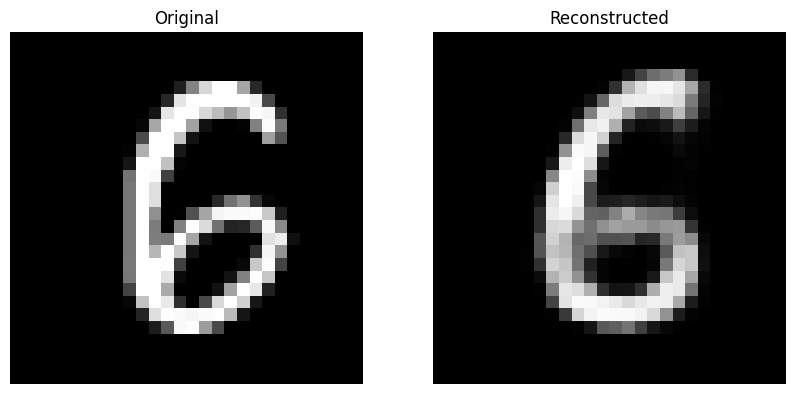

Epoch [8/10], Train Loss: 0.0192, Val Loss: 0.0161, Val SSIM: 0.8385


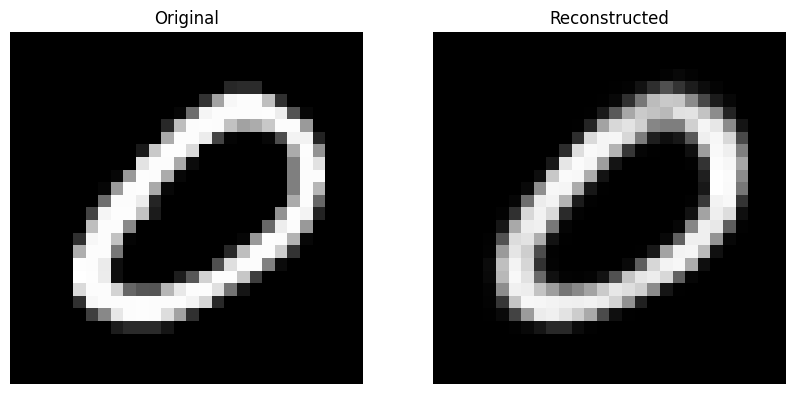

Epoch [9/10], Train Loss: 0.0184, Val Loss: 0.0156, Val SSIM: 0.8442


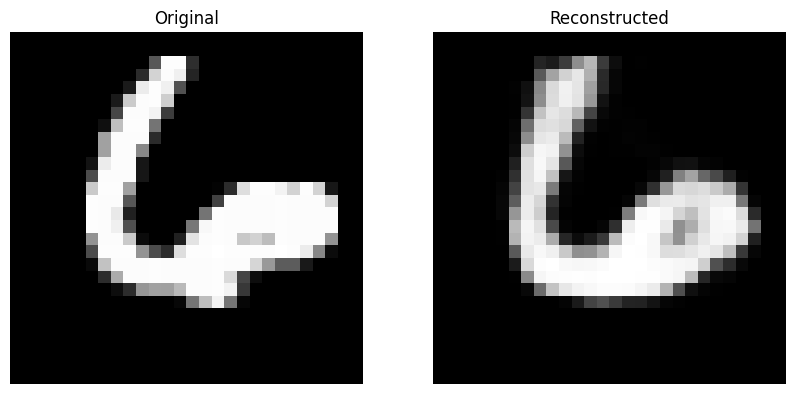

Epoch [10/10], Train Loss: 0.0177, Val Loss: 0.0150, Val SSIM: 0.8488
Training finished.


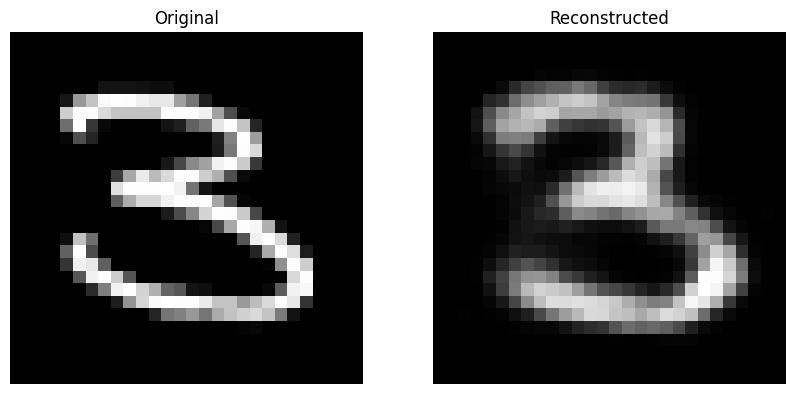

bottleneck value completed 32 avg ssim 0.8522455664372676
******************************************************************

BOTTLENECK: 64


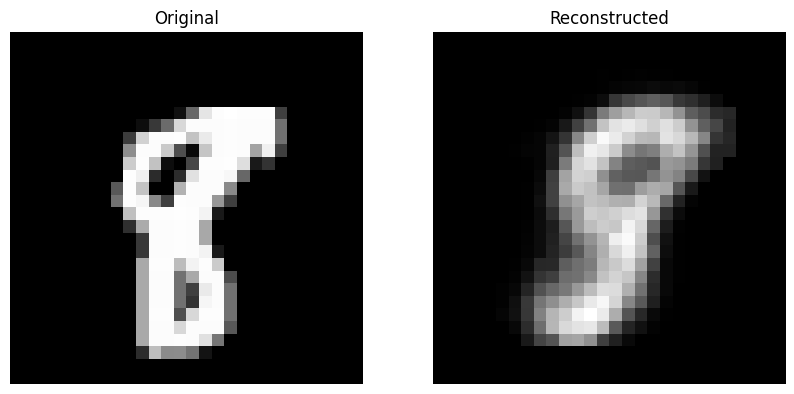

Epoch [1/10], Train Loss: 0.0639, Val Loss: 0.0424, Val SSIM: 0.5619


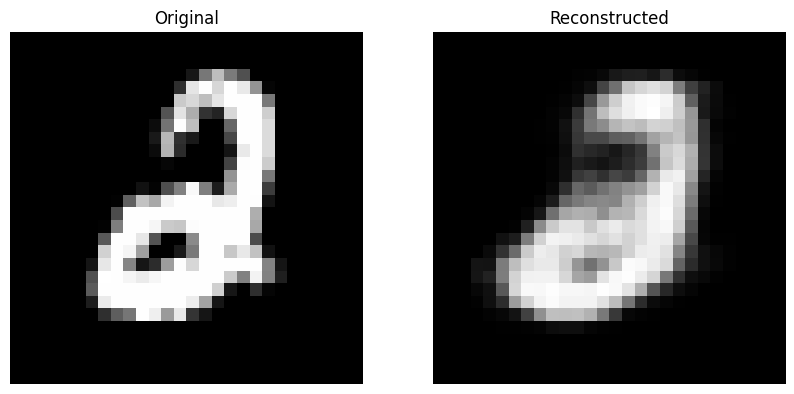

Epoch [2/10], Train Loss: 0.0366, Val Loss: 0.0296, Val SSIM: 0.6931


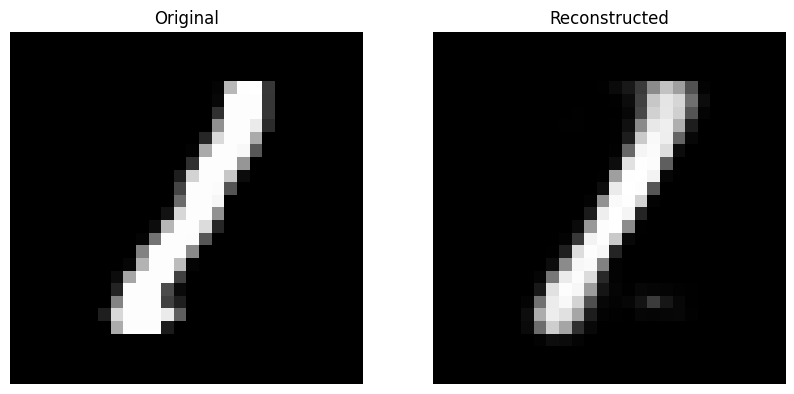

Epoch [3/10], Train Loss: 0.0301, Val Loss: 0.0265, Val SSIM: 0.7286


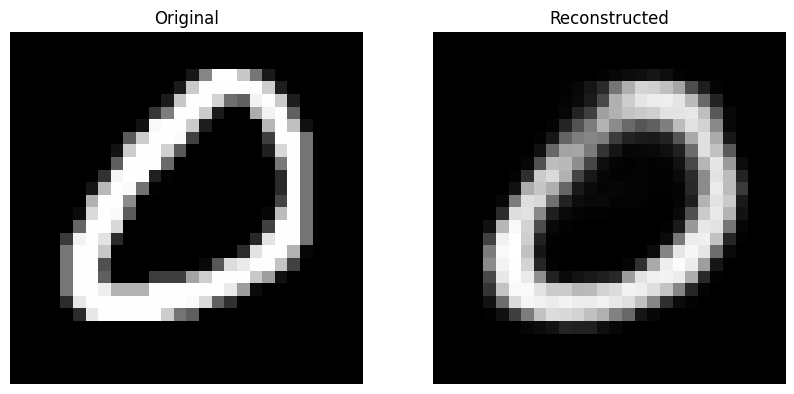

Epoch [4/10], Train Loss: 0.0273, Val Loss: 0.0236, Val SSIM: 0.7610


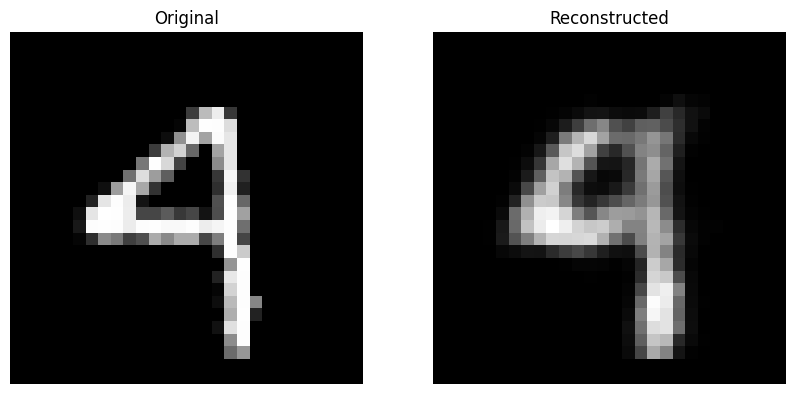

Epoch [5/10], Train Loss: 0.0251, Val Loss: 0.0216, Val SSIM: 0.7805


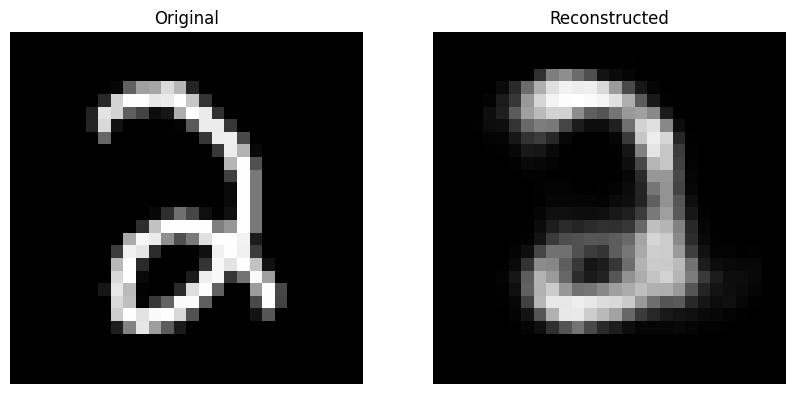

Epoch [6/10], Train Loss: 0.0230, Val Loss: 0.0197, Val SSIM: 0.8011


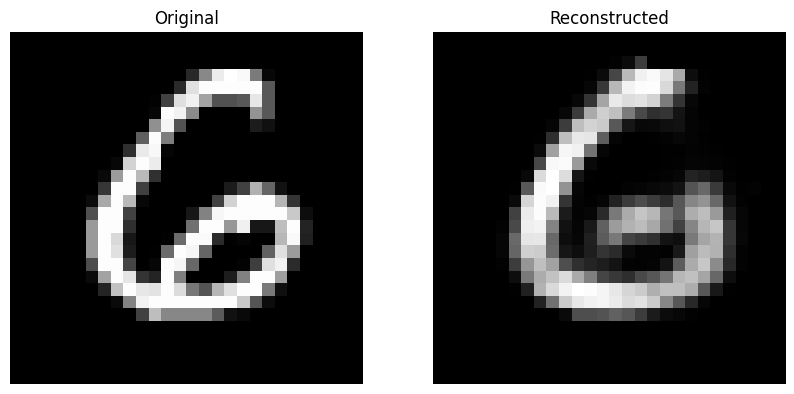

Epoch [7/10], Train Loss: 0.0214, Val Loss: 0.0185, Val SSIM: 0.8144


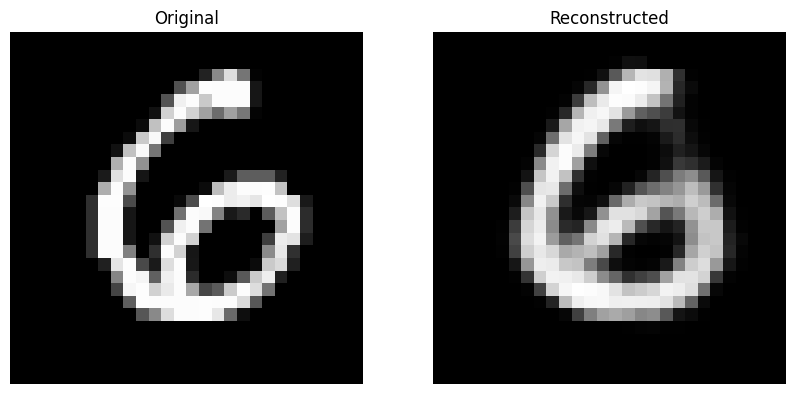

Epoch [8/10], Train Loss: 0.0204, Val Loss: 0.0177, Val SSIM: 0.8224


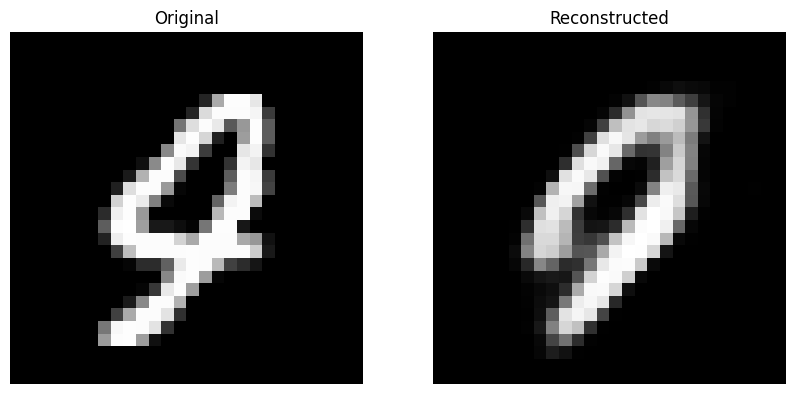

Epoch [9/10], Train Loss: 0.0193, Val Loss: 0.0164, Val SSIM: 0.8368


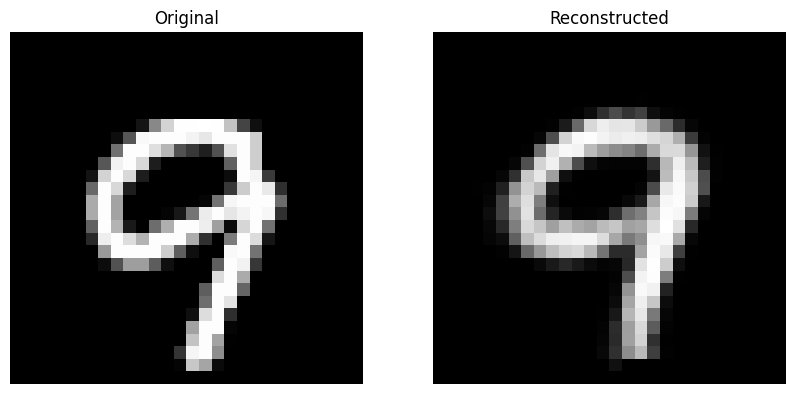

Epoch [10/10], Train Loss: 0.0185, Val Loss: 0.0157, Val SSIM: 0.8424
Training finished.


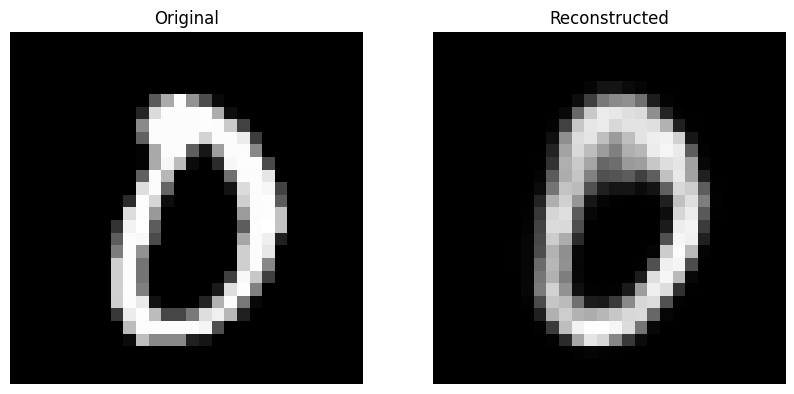

bottleneck value completed 64 avg ssim 0.8455078066018923


In [41]:
# Define sigma values to test
sigma= 0.05
avg_ssim_scores = []
avg_loss=[]
bottleneck_values = [1,16,32,64]
for bottleneck in bottleneck_values:
    print("******************************************************************\n")
    print("BOTTLENECK:",bottleneck)
    model2 = AutoEncoder2(bottleneck)
    model2 = model2.to(device)
    optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)
    train_model(model2, 10, train_loader,val_loader, optimizer2, criterion,sigma,1)
    loss,ssim_value = evaluate_model(model2, test_loader,criterion)
    avg_ssim_scores.append(ssim_value)
    avg_loss.append(loss)
    print("bottleneck value completed",bottleneck,"avg ssim",ssim_value)


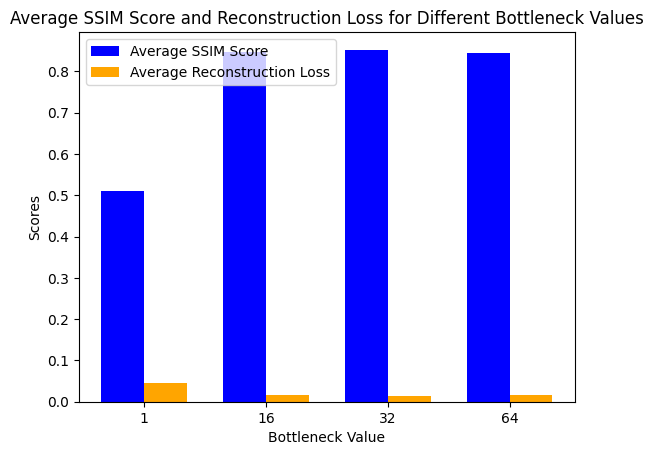

In [42]:
bar_width = 0.35
index = range(len(bottleneck_values))
fig, ax = plt.subplots()
bar1 = ax.bar(index, avg_ssim_scores, bar_width, label='Average SSIM Score', color='blue')
bar2 = ax.bar([i + bar_width for i in index], avg_loss, bar_width, label='Average Reconstruction Loss', color='orange')

# Add labels and title
ax.set_xlabel('Bottleneck Value')
ax.set_ylabel('Scores')
ax.set_title('Average SSIM Score and Reconstruction Loss for Different Bottleneck Values')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(bottleneck_values)
ax.legend()

# Show plot
plt.show()


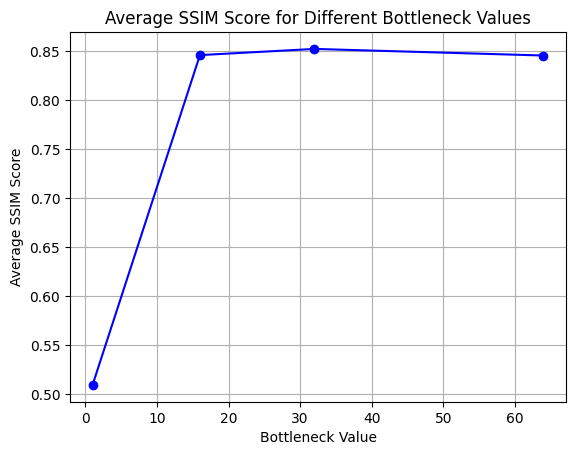

In [44]:
# Plotting only SSIM scores
plt.plot(bottleneck_values, avg_ssim_scores, marker='o', color='blue')

# Add labels and title
plt.xlabel('Bottleneck Value')
plt.ylabel('Average SSIM Score')
plt.title('Average SSIM Score for Different Bottleneck Values')

# Show plot
plt.grid(True)
plt.show()


FINAL OBSERVATIONS:
- Changing Bottleneck Values: As the bottleneck values increase, the SSIM increases. This is because increasing the bottleneck size results in less compression during encoding. With a larger bottleneck, more information is retained, leading to a better reconstruction of the input image and hence a higher SSIM.

- Adding Gaussian Noise During Training: When Gaussian noise is added during training, as the sigma (standard deviation) of the noise increases, the SSIM decreases. This is because training is being done on noisy data, which makes it more difficult for the autoencoder to reconstruct the original image accurately. As a result, the quality of the reconstruction decreases, leading to a lower SSIM score.